In [56]:
#ライブラリ、モジュールのインポート
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.font_manager as fm
import geopandas as gpd
from geopy.geocoders import Nominatim
from shapely.geometry import Point
import re

In [57]:
# CSVファイルの読み込み
csv_file = '/home/yasumasa-tezuka/intern_data/140007_park_(神奈川県公園データ).csv'  
df = pd.read_csv(csv_file, encoding='utf-8-sig')

# Excelファイルとして保存
file_path = '/home/yasumasa-tezuka/intern_data/140007_park_(神奈川県公園データ)1.xlsx'
df.to_excel(file_path, index=False)

In [58]:
# データの前処理
# Excelファイルの読み込み(公園データ)
file_path = '/home/yasumasa-tezuka/intern_data/140007_park_(神奈川県公園データ)1.xlsx'  
df = pd.read_excel(file_path)

# '面積'の列名を'公園面積'に変更
df.rename(columns={'面積': '公園面積'}, inplace=True)

def extract_municipality_custom(address):
    if pd.isna(address) or not isinstance(address, str):
        return ''
    
    if '神奈川県三崎町小網代1023-1' in address:
        return '三浦市'
    
    # 神奈川県の部分を削除
    address = address.replace('神奈川県', '')

    # 特定のパターン「瀬谷区下瀬谷二丁目９番15」の処理
    if '瀬谷区下瀬谷二丁目９番15' in address:
        return '横浜市瀬谷区'

    # 特定の市の場合は区までの記述にする
    for special_city in ['横浜市', '川崎市', '相模原市']:
        if special_city in address:
            return address.split('区')[0] + '区'

    # 通常の市区町村名の抽出
    for keyword in ['市', '町', '村']:
        if keyword in address:
            return address.split(keyword)[0] + keyword

    return address

# D列の住所を変換してE列に保存
df['市区町村'] = df['所在地'].apply(extract_municipality_custom)

# 変更をExcelファイルに保存
data_path = '/home/yasumasa-tezuka/intern_data/140007_park_(神奈川県公園データ)_修正版.xlsx'  
df.to_excel(data_path, index=False)

In [59]:
#データの確認
print(park_data.columns)
print(park_data.info())

Index(['No.', '自治体名', '名称', '所在地', '提供開始年', '公園面積', '公園種別', 'トイレ', '多目的トイレ',
       '水飲み・手洗い', 'スプリング遊具・スイング遊具', '砂場', '複合遊具', '健康器具', 'ブランコ', 'すべり台',
       'ジャングルジム', '鉄棒', 'シーソー', 'ターザンロープ', 'ローラースライダー', 'ふわふわドーム', '芝生広場',
       '水遊び', 'ランニングコース', 'テニスコート', 'バスケットゴール', '野球場', 'フットサル場', 'サッカー場',
       'スケートパーク', 'プール', '体育館', '陸上競技場', 'ウサギ・モルモット', 'ハムスター', 'ひよこ', '馬・ポニー',
       'カフェ・飲食施設', '売店', '自動販売機', 'バーベキュー場', 'ドッグラン', '喫煙所', 'イベント広場', '避難場所',
       '無料駐車場', '有料駐車場', '駐輪場', '開園時間', '休園日', '関連リンク', '備考', '最終更新日', '市区町村'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8031 entries, 0 to 8030
Data columns (total 55 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   No.             8030 non-null   float64
 1   自治体名            8030 non-null   object 
 2   名称              8030 non-null   object 
 3   所在地             8029 non-null   object 
 4   提供開始年           8030 non-null   object 
 5   公園面積         

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

import pandas as pd
# ファイルの読み込み
park_data_1 = '/home/yasumasa-tezuka/intern_data/140007_park_(神奈川県公園データ)_修正版.xlsx'
population_data_path = '/home/yasumasa-tezuka/intern_data/jinkotosetai_r5_10.xlsx'
park_data = pd.read_excel(park_data_1)
df_population = pd.read_excel(population_data_path)

# 公園データの前処理
columns_to_drop_parks = ['No.', '自治体名', '名称', '最終更新日']  # 分析に不要な列
df_parks_cleaned = park_data.drop(columns=columns_to_drop_parks)
df_parks_cleaned = df_parks_cleaned.fillna(0)  # 欠損値を0で埋める

# '公園面積'列を数値型に変換（変換できない値はNaNになる）
df_parks_cleaned['公園面積'] = pd.to_numeric(df_parks_cleaned['公園面積'], errors='coerce')

# NaN値を0で置き換える
df_parks_cleaned['公園面積'] = df_parks_cleaned['公園面積'].fillna(0)

# 各市区町村ごとに公園面積の合計を計算
park_area_by_city = df_parks_cleaned.groupby('市区町村')['公園面積'].sum().reset_index()

# '人口総数'列が文字列型であるか確認
if not pd.api.types.is_string_dtype(df_population['人口総数']):
    df_population['人口総数'] = df_population['人口総数'].astype(str)

# '人口総数'列の数値を適切に処理
df_population['人口総数'] = df_population['人口総数'].str.replace(',', '').astype(float)

# 不要な列の削除
df_population = df_population.loc[:, ~df_population.columns.str.contains('^Unnamed')]

# 人口データと公園データの結合
merged_df = pd.merge(df_population, park_area_by_city, how='left', left_on='市区町村', right_on='市区町村')

# 人口一人当たりの公園面積を計算
merged_df['公園面積_per_capita'] = merged_df['公園面積'] / merged_df['人口総数']
# 結果の表示
print(merged_df)

        市区町村      世帯      人口総数          人口密度        公園面積  公園面積_per_capita
0     横浜市鶴見区  148526  295863.0   8906.170981   819346.00         2.769343
1    横浜市神奈川区  133749  249773.0  10525.621576   855699.00         3.425907
2      横浜市西区   59228  106417.0  15137.553343   279891.00         2.630134
3      横浜市中区   87497  151931.0   6988.546458  1011028.00         6.654521
4      横浜市南区  107869  198934.0  15726.007905   428747.00         2.155222
5     横浜市港南区   97504  213805.0  10743.969849   799916.00         3.741334
6   横浜市保土ケ谷区  100982  205790.0   9383.948928   993288.00         4.826707
7      横浜市旭区  108396  241767.0   7386.709441  1865140.00         7.714618
8     横浜市磯子区   79912  165196.0   8671.706037   457731.00         2.770836
9     横浜市金沢区   90936  195201.0   6304.941860  2965678.00        15.192945
10    横浜市港北区  181173  363097.0  11563.598726  1451103.00         3.996461
11     横浜市緑区   81666  182981.0   7172.912583  1257321.00         6.871320
12    横浜市青葉区  135860  309399.0   8784.

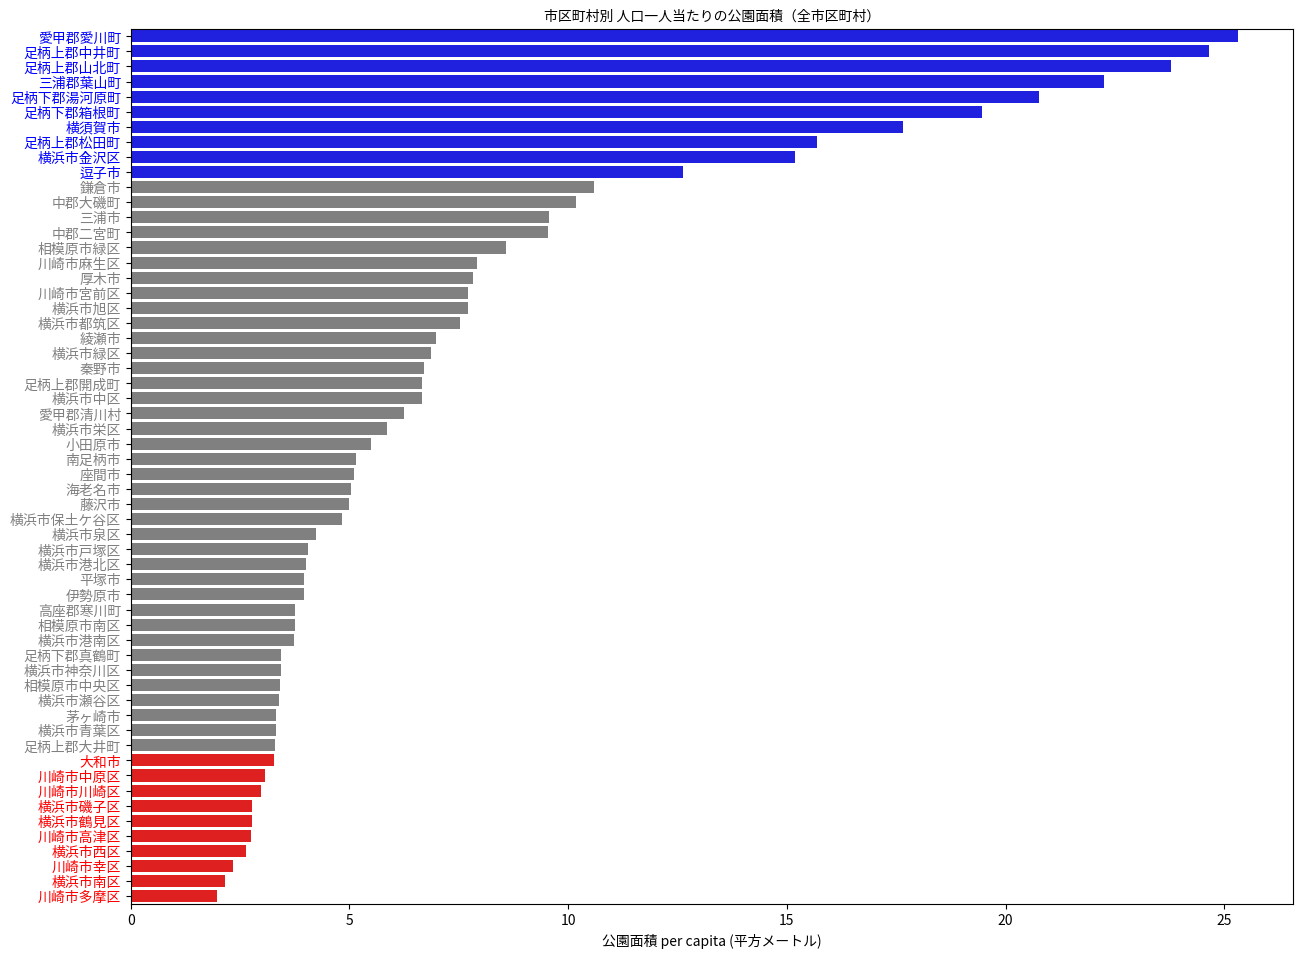

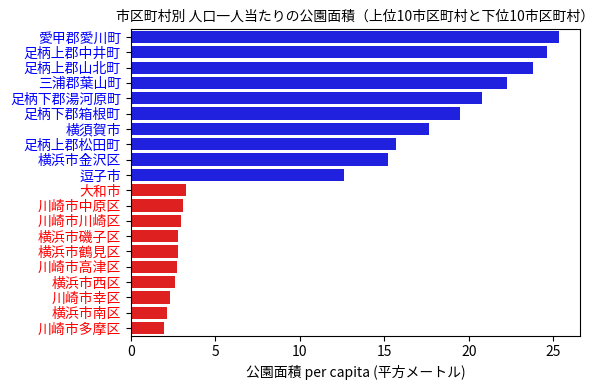

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import pandas as pd

# 日本語フォントの設定
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'
font_prop = fm.FontProperties(fname=font_path)

plt.rcParams['font.family'] = font_prop.get_name()

# データの準備
sorted_df = merged_df.sort_values('公園面積_per_capita', ascending=False)

# 上位10市区町村と下位10市区町村の取得
top_10 = sorted_df.head(10)
bottom_10 = sorted_df.tail(10)

# カラーマッピング用の列を追加（全市区町村データ用）
sorted_df['color'] = ['top' if name in top_10['市区町村'].values else 'bottom' if name in bottom_10['市区町村'].values else 'other' for name in sorted_df['市区町村']]

# 上位10市区町村と下位10市区町村のみのデータフレームを作成
top_bottom_df = pd.concat([top_10, bottom_10])

# カラーマッピング用の列を追加（上位・下位データ用）
top_bottom_df['color'] = ['top' if name in top_10['市区町村'].values else 'bottom' for name in top_bottom_df['市区町村']]

# カラーパレットの設定
palette = {'top': 'blue', 'bottom': 'red', 'other': 'grey'}

# データの可視化（全市区町村）
plt.figure(figsize=(15, 25))
plt.subplot(2, 1, 1)  # 2行1列のグリッドの1番目のプロット
barplot_all = sns.barplot(x='公園面積_per_capita', y='市区町村', data=sorted_df, hue='color', palette=palette, dodge=False)
barplot_all.get_legend().remove()

# 市区町村名の色の設定（全市区町村）
for label in barplot_all.get_yticklabels():
    name = label.get_text()
    color = sorted_df[sorted_df['市区町村'] == name].iloc[0]['color']
    label.set_color(palette.get(color, 'grey'))  # 色がない場合は灰色を使用

plt.title('市区町村別 人口一人当たりの公園面積（全市区町村）', fontproperties=font_prop)
plt.xlabel('公園面積 per capita (平方メートル)', fontproperties=font_prop)
plt.ylabel('')
plt.xticks(fontproperties=font_prop)

# データの可視化（上位10市区町村と下位10市区町村のみ）
plt.figure(figsize=(6, 4))  # グラフのサイズを調整
barplot_top_bottom = sns.barplot(x='公園面積_per_capita', y='市区町村', data=top_bottom_df, hue='color', palette=palette, dodge=False)
barplot_top_bottom.get_legend().remove()

# 市区町村名の色の設定（上位10市区町村と下位10市区町村）
for label in barplot_top_bottom.get_yticklabels():
    name = label.get_text()
    color = top_bottom_df[top_bottom_df['市区町村'] == name].iloc[0]['color']
    label.set_color(palette[color])

plt.title('市区町村別 人口一人当たりの公園面積（上位10市区町村と下位10市区町村）', fontproperties=font_prop)
plt.xlabel('公園面積 per capita (平方メートル)', fontproperties=font_prop)
plt.ylabel('')
plt.xticks(fontproperties=font_prop)

plt.tight_layout()  # サブプロット間のスペースを調整
plt.show()

In [63]:
# 公園データの読み込み
#公園種別、所在地、面積、設備
file_path_1 = '/home/yasumasa-tezuka/intern_data/140007_park_(神奈川県公園データ)_修正版.xlsx'
park_data = pd.read_excel(file_path_1)

#140007_park_(神奈川県公園データ)_修正版.xlsxファイルの「面積」の項目を「公園面積」に変更
park_data.rename(columns={'面積': '公園面積'}, inplace=True)
# "公園面積" 列が文字列型の場合は数値型に変換
park_data['公園面積'] = pd.to_numeric(park_data['公園面積'], errors='coerce')

# 変換を適用する列のリスト
# トイレから駐輪場の列を数値型に変換（例: 有=1, 無=0）
columns_to_convert = ['トイレ', '多目的トイレ', '水飲み・手洗い', 'スプリング遊具・スイング遊具', '砂場', '複合遊具', '健康器具', 'ブランコ', 'すべり台', 'ジャングルジム',
                   '鉄棒', 'シーソー', 'ターザンロープ', 'ローラースライダー', 'ふわふわドーム', '芝生広場', '水遊び', 'ランニングコース', 'テニスコート', 'バスケットゴール',
                   '野球場', 'フットサル場', 'サッカー場', 'スケートパーク', 'プール', '体育館', '陸上競技場', 'ウサギ・モルモット', 'ハムスター', 'ひよこ', '馬・ポニー',
                   'カフェ・飲食施設', '売店', '自動販売機', 'バーベキュー場', 'ドッグラン', '喫煙所', 'イベント広場', '避難場所', '無料駐車場', '有料駐車場', '駐輪場']

# 各設備の列の変換処理
for col in columns_to_convert:
    # '-' を 0 に置き換える
    park_data[col] = park_data[col].replace('-', 0)

    # 空欄（NaN）を 0 に置き換える
    park_data[col] = pd.to_numeric(park_data[col], errors='coerce').fillna(0)
    
# 市区町村ごとの公園の数、総面積、平均面積を集計
park_stats = park_data.groupby('市区町村').agg({'No.': 'count', '公園面積': ['sum', 'mean']})
park_stats.columns = ['公園数', '総面積', '平均面積']

# 設備の数を市区町村ごとに集計
facility_stats = park_data.groupby('市区町村')[columns_to_convert].sum()

# 結果の表示
print(park_stats)
print(facility_stats)

          公園数         総面積          平均面積
市区町村                                   
三浦市        64   384977.00   6015.265625
三浦郡葉山町     48   692559.00  14428.312500
中郡二宮町      53   257317.00   4855.037736
中郡大磯町      54   316782.00   5866.333333
伊勢原市      149   400733.00   2689.483221
南足柄市       28   204659.00   7309.250000
厚木市       241  1755292.00   7283.369295
大和市       244   794329.00   3255.446721
小田原市      154  1024883.00   6655.084416
川崎市中原区    109   818671.00   7510.743119
川崎市多摩区    150   446194.00   2974.626667
川崎市宮前区    216  1814565.00   8400.763889
川崎市川崎区    152   685941.00   4512.769737
川崎市幸区     108   401515.00   3717.731481
川崎市高津区    164   647166.00   3946.134146
川崎市麻生区    325  1428938.00   4396.732308
平塚市       282  1023049.00   3653.746429
座間市        46   674596.00  14665.130435
愛甲郡愛川町     22   995034.00  45228.818182
愛甲郡清川村      1    18210.00  18210.000000
横浜市中区      90  1011028.00  11233.644444
横浜市保土ケ谷区  168   993288.00   5912.428571
横浜市南区     131   428747.00   3272.877863


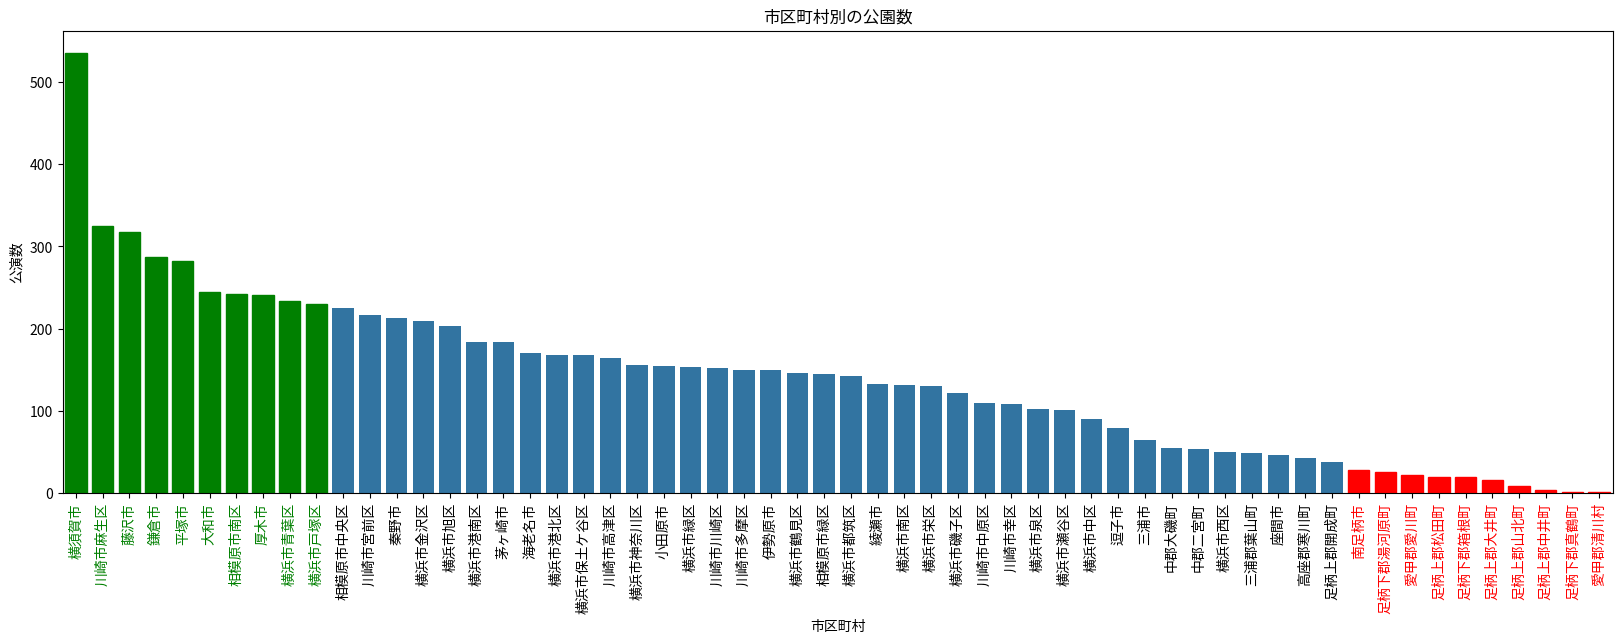

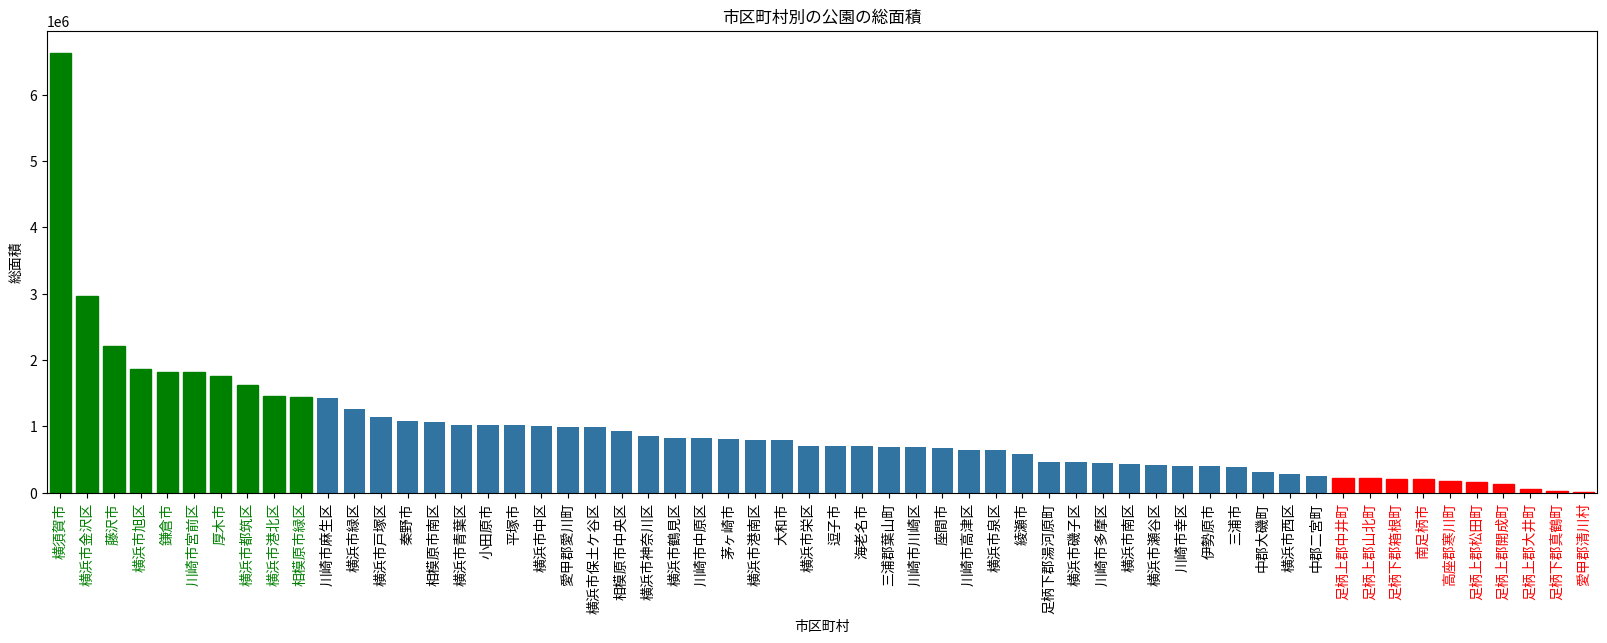

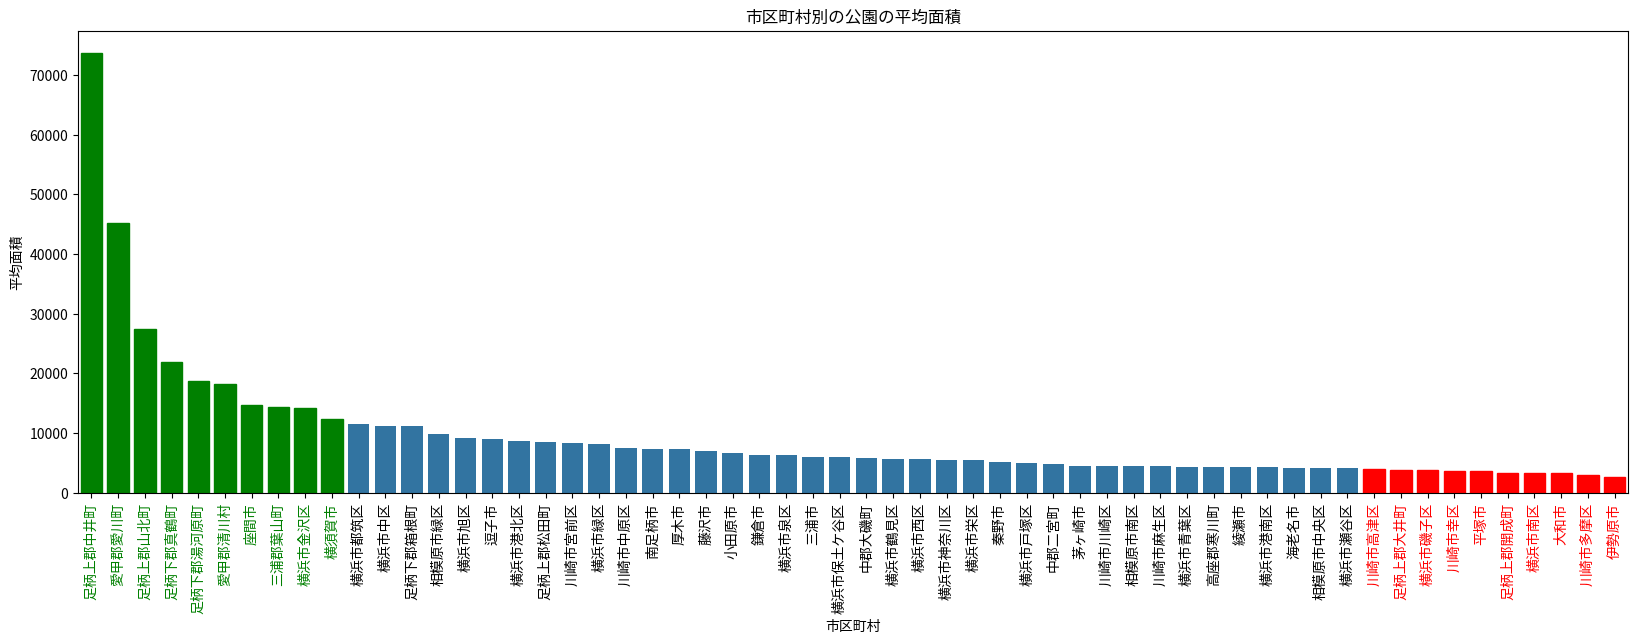

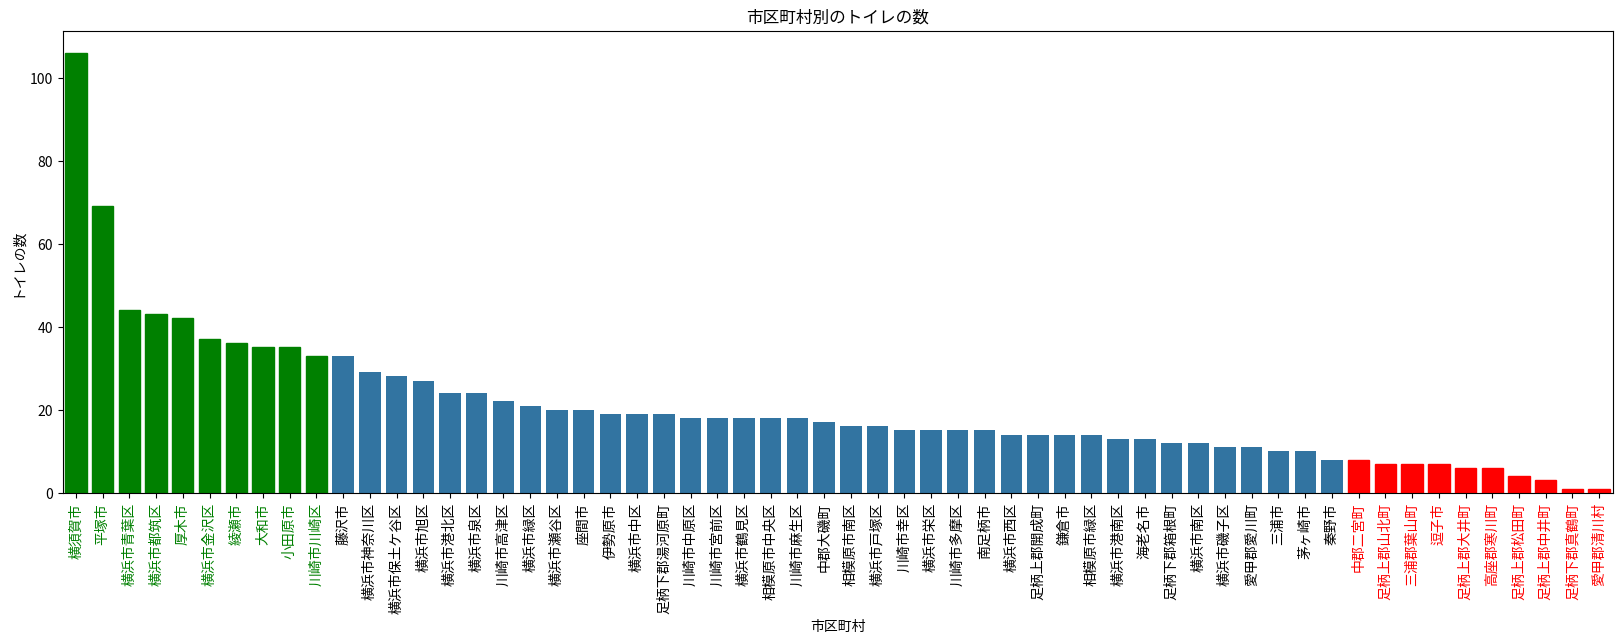

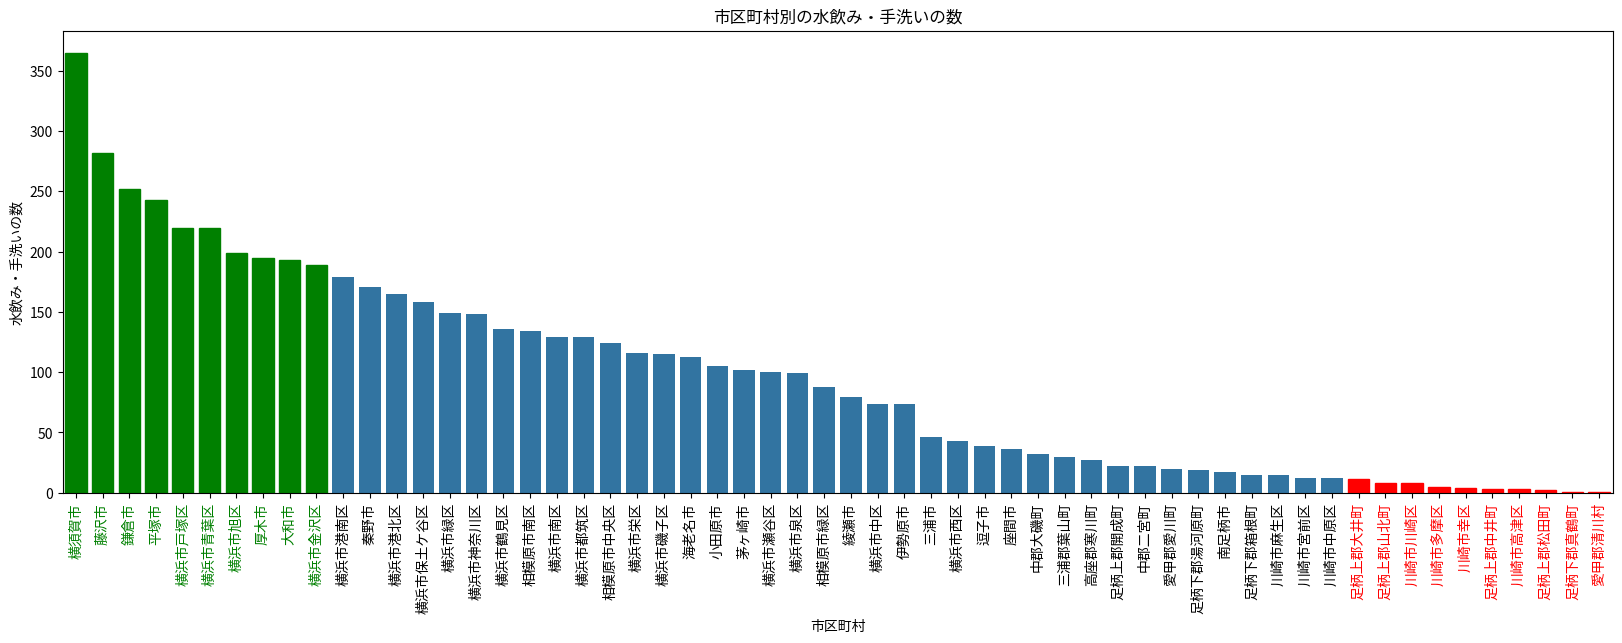

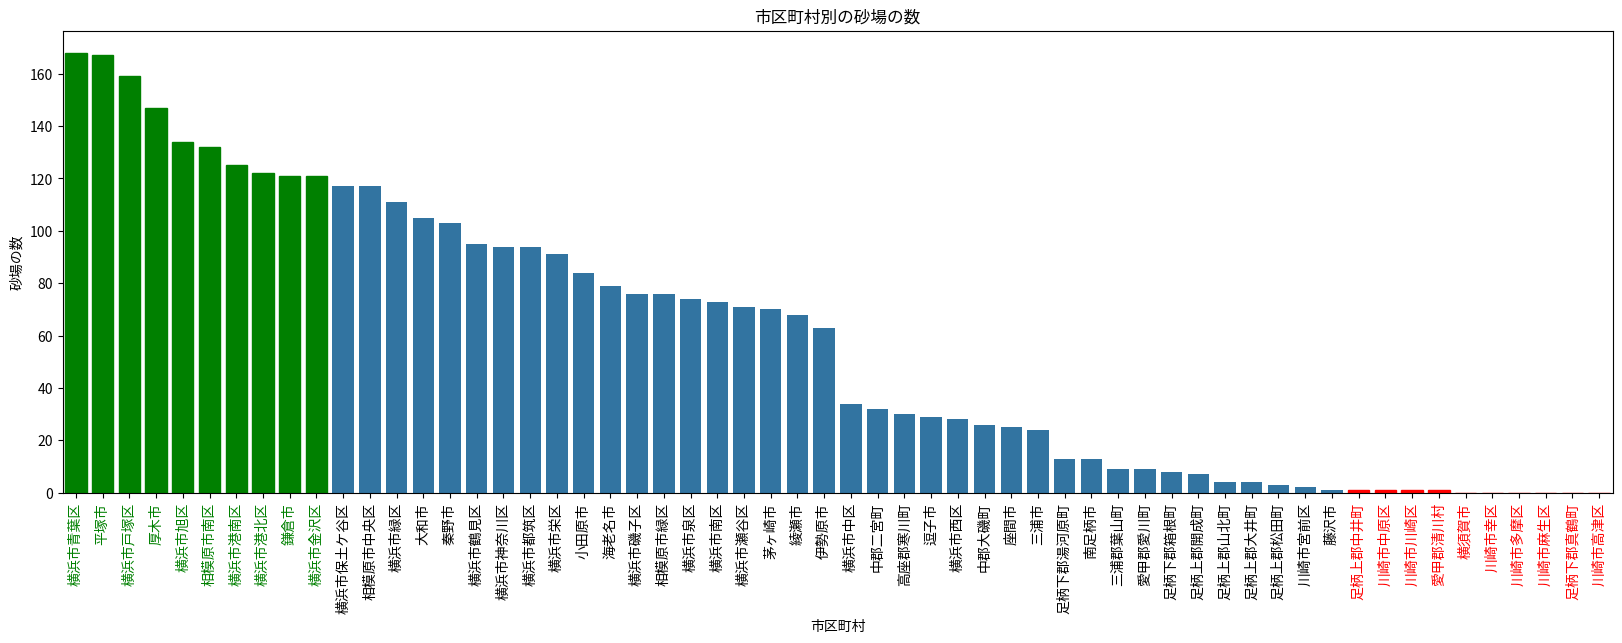

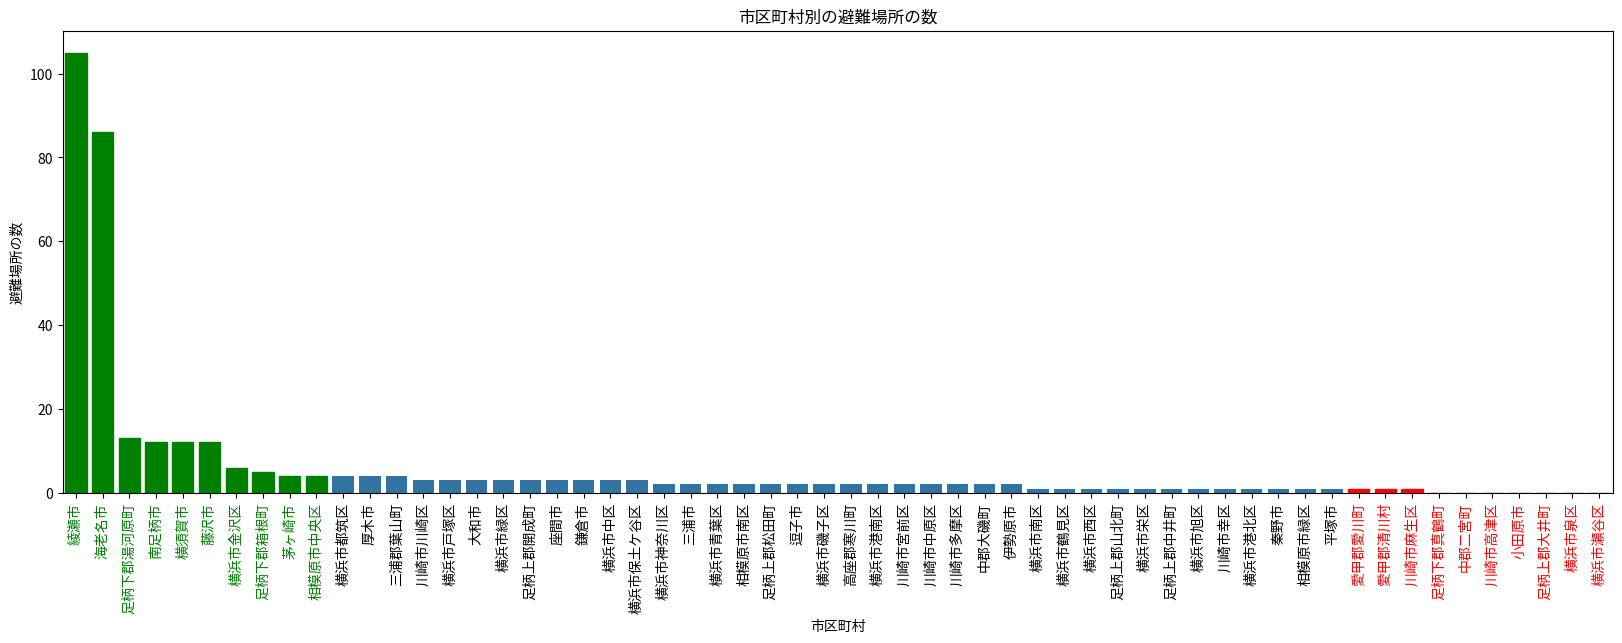

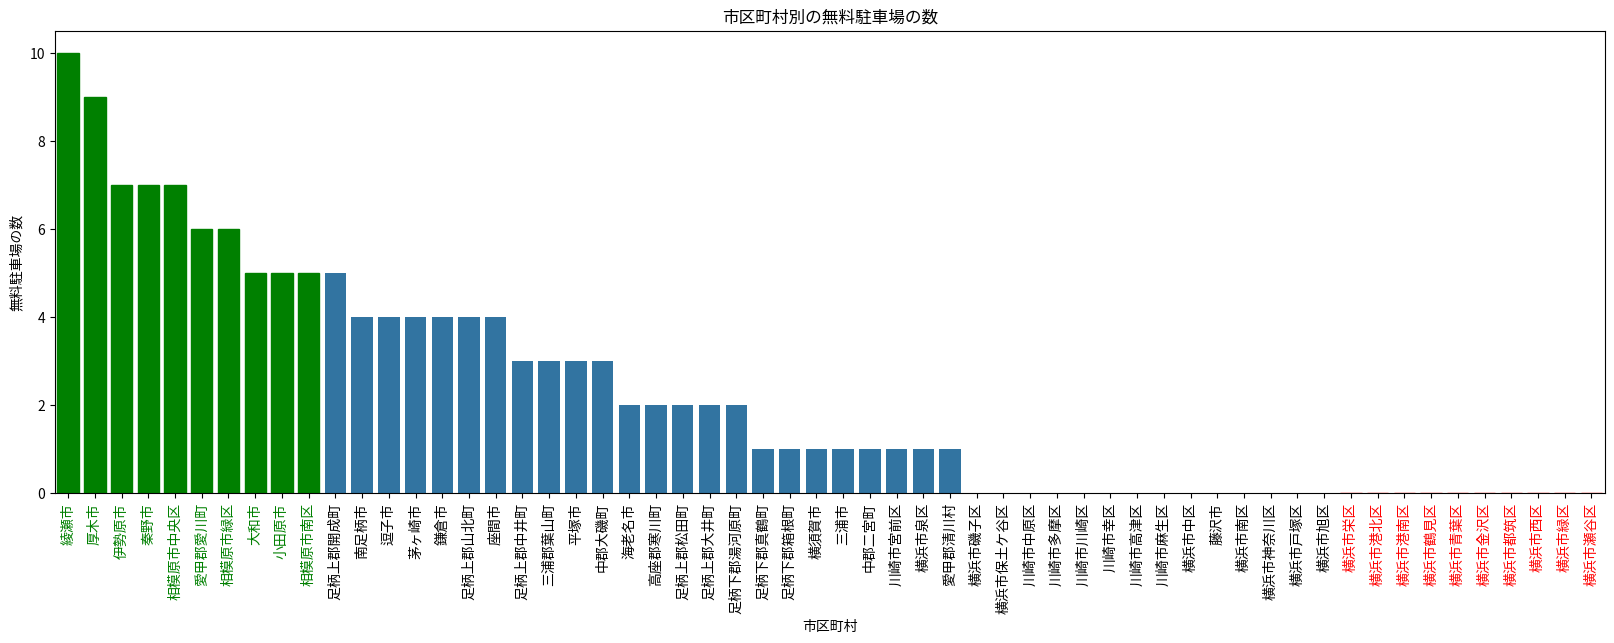

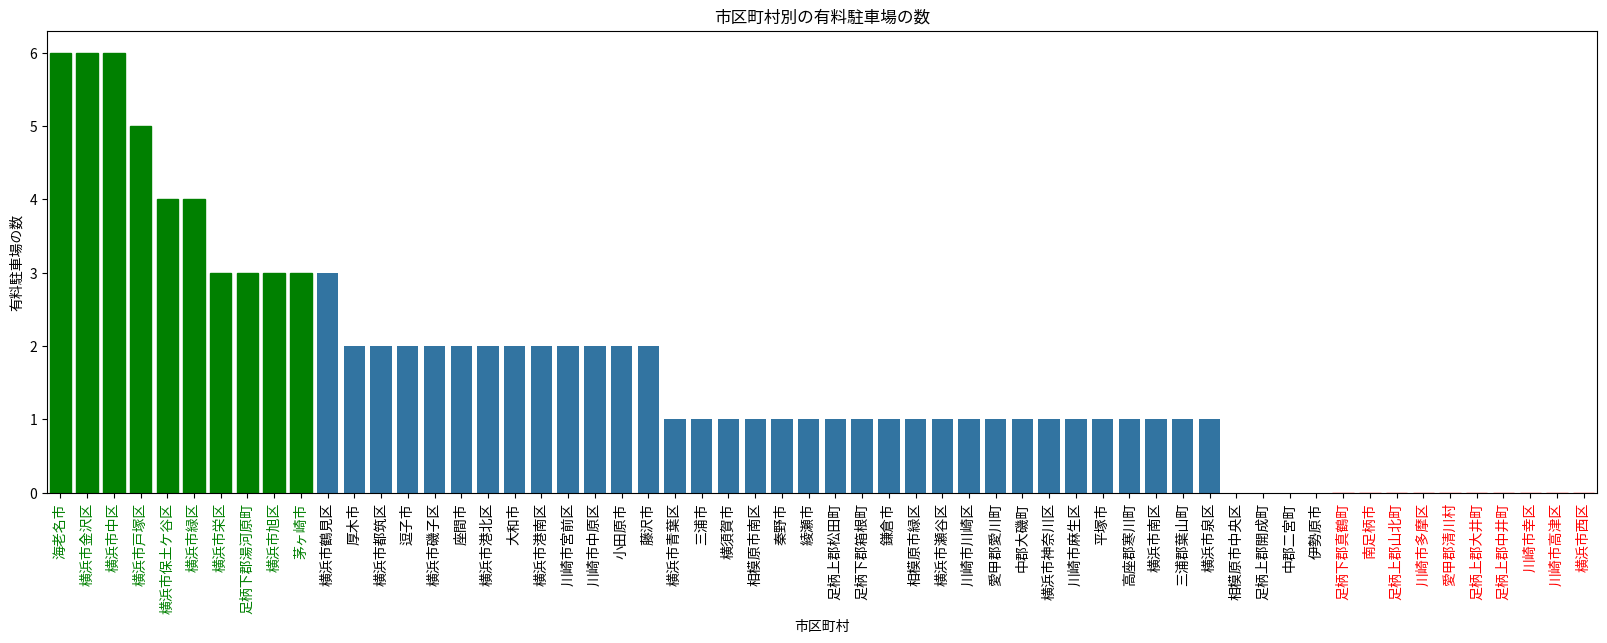

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# 公園の数でソート
sorted_park_stats = park_stats.sort_values(by='公園数', ascending=False)

# 値の高い10市区町村と値の低い10市区町村のインデックス取得
top_10 = sorted_park_stats.head(10).index
bottom_10 = sorted_park_stats.tail(10).index

# 可視化
plt.figure(figsize=(20, 6))
barplot = sns.barplot(x=sorted_park_stats.index, y='公園数', data=sorted_park_stats)

# 特定のバーと対応するラベルの色を変更
for idx, label in enumerate(barplot.get_xticklabels()):
    text = label.get_text()
    if text in top_10:
        barplot.patches[idx].set_color('green')  # 値の高い3市区町村のバーの色
        label.set_color('green')  # ラベルの色
    elif text in bottom_10:
        barplot.patches[idx].set_color('red')  # 値の低い3市区町村のバーの色
        label.set_color('red')  # ラベルの色

plt.xticks(rotation=90)
plt.title('市区町村別の公園数')
plt.ylabel('公演数')
plt.show()

#総面積の可視化
# 公園の数でソート
sorted_park_stats = park_stats.sort_values(by='総面積', ascending=False)

# 値の高い10市区町村と値の低い10市区町村のインデックス取得
top_10 = sorted_park_stats.head(10).index
bottom_10 = sorted_park_stats.tail(10).index

# 可視化
plt.figure(figsize=(20, 6))
barplot = sns.barplot(x=sorted_park_stats.index, y='総面積', data=sorted_park_stats)

# 特定のバーと対応するラベルの色を変更
for idx, label in enumerate(barplot.get_xticklabels()):
    text = label.get_text()
    if text in top_10:
        barplot.patches[idx].set_color('green')  # 値の高い3市区町村のバーの色
        label.set_color('green')  # ラベルの色
    elif text in bottom_10:
        barplot.patches[idx].set_color('red')  # 値の低い3市区町村のバーの色
        label.set_color('red')  # ラベルの色

plt.xticks(rotation=90)
plt.title('市区町村別の公園の総面積')
plt.ylabel('総面積')
plt.show()

#平均面積の可視化
# 公園の数でソート
sorted_park_stats = park_stats.sort_values(by='平均面積', ascending=False)

# 値の高い10市区町村と値の低い10市区町村のインデックス取得
top_10 = sorted_park_stats.head(10).index
bottom_10 = sorted_park_stats.tail(10).index

# 可視化
plt.figure(figsize=(20, 6))
barplot = sns.barplot(x=sorted_park_stats.index, y='平均面積', data=sorted_park_stats)

# 特定のバーと対応するラベルの色を変更
for idx, label in enumerate(barplot.get_xticklabels()):
    text = label.get_text()
    if text in top_10:
        barplot.patches[idx].set_color('green')  # 値の高い3市区町村のバーの色
        label.set_color('green')  # ラベルの色
    elif text in bottom_10:
        barplot.patches[idx].set_color('red')  # 値の低い3市区町村のバーの色
        label.set_color('red')  # ラベルの色

plt.xticks(rotation=90)
plt.title('市区町村別の公園の平均面積')
plt.ylabel('平均面積')
plt.show()

# 設備：トイレの可視化
# トイレの数でソート
sorted_facility_stats = facility_stats.sort_values(by='トイレ', ascending=False)

# 値の高い10町村と値の低い10市区町村のインデックス取得
top_10 = sorted_facility_stats.head(10).index
bottom_10 = sorted_facility_stats.tail(10).index

# 可視化
plt.figure(figsize=(20, 6))
barplot = sns.barplot(x=sorted_facility_stats.index, y='トイレ', data=sorted_facility_stats)

# 特定のバーと対応するラベルの色を変更
for idx, label in enumerate(barplot.get_xticklabels()):
    text = label.get_text()
    if text in top_10:
        barplot.patches[idx].set_color('green')  # 値の高い市区町村のバーの色
        label.set_color('green')  # ラベルの色
    elif text in bottom_10:
        barplot.patches[idx].set_color('red')  # 値の低い市区町村のバーの色
        label.set_color('red')  # ラベルの色

plt.xticks(rotation=90)
plt.title('市区町村別のトイレの数')
plt.ylabel('トイレの数')
plt.show()

# 設備：水飲み・手洗いの可視化
# 水飲み・手洗いの数でソート
sorted_facility_stats = facility_stats.sort_values(by='水飲み・手洗い', ascending=False)

# 値の高い10市区町村と値の低い10市区町村のインデックス取得
top_10 = sorted_facility_stats.head(10).index
bottom_10 = sorted_facility_stats.tail(10).index

# 可視化
plt.figure(figsize=(20, 6))
barplot = sns.barplot(x=sorted_facility_stats.index, y='水飲み・手洗い', data=sorted_facility_stats)

# 特定のバーと対応するラベルの色を変更
for idx, label in enumerate(barplot.get_xticklabels()):
    text = label.get_text()
    if text in top_10:
        barplot.patches[idx].set_color('green')  # 値の高い市区町村のバーの色
        label.set_color('green')  # ラベルの色
    elif text in bottom_10:
        barplot.patches[idx].set_color('red')  # 値の低い市区町村のバーの色
        label.set_color('red')  # ラベルの色

plt.xticks(rotation=90)
plt.title('市区町村別の水飲み・手洗いの数')
plt.ylabel('水飲み・手洗いの数')
plt.show()

# 設備：砂場の可視化
# 砂場の数でソート
sorted_facility_stats = facility_stats.sort_values(by='砂場', ascending=False)

# 値の高い10市区町村と値の低い10市区町村のインデックス取得
top_10 = sorted_facility_stats.head(10).index
bottom_10 = sorted_facility_stats.tail(10).index

# 可視化
plt.figure(figsize=(20, 6))
barplot = sns.barplot(x=sorted_facility_stats.index, y='砂場', data=sorted_facility_stats)

# 特定のバーと対応するラベルの色を変更
for idx, label in enumerate(barplot.get_xticklabels()):
    text = label.get_text()
    if text in top_10:
        barplot.patches[idx].set_color('green')  # 値の高い市区町村のバーの色
        label.set_color('green')  # ラベルの色
    elif text in bottom_10:
        barplot.patches[idx].set_color('red')  # 値の低い市区町村のバーの色
        label.set_color('red')  # ラベルの色

plt.xticks(rotation=90)
plt.title('市区町村別の砂場の数')
plt.ylabel('砂場の数')
plt.show()

# 避難場所の可視化
# 避難場所の数でソート
sorted_facility_stats = facility_stats.sort_values(by='避難場所', ascending=False)

# 値の高い10市区町村と値の低い10市区町村のインデックス取得
top_10 = sorted_facility_stats.head(10).index
bottom_10 = sorted_facility_stats.tail(10).index

# 可視化
plt.figure(figsize=(20, 6))
barplot = sns.barplot(x=sorted_facility_stats.index, y='避難場所', data=sorted_facility_stats)

# 特定のバーと対応するラベルの色を変更
for idx, label in enumerate(barplot.get_xticklabels()):
    text = label.get_text()
    if text in top_10:
        barplot.patches[idx].set_color('green')  # 値の高い市区町村のバーの色
        label.set_color('green')  # ラベルの色
    elif text in bottom_10:
        barplot.patches[idx].set_color('red')  # 値の低い市区町村のバーの色
        label.set_color('red')  # ラベルの色

plt.xticks(rotation=90)
plt.title('市区町村別の避難場所の数')
plt.ylabel('避難場所の数')
plt.show()

# 設備：無料駐車場の可視化
# 無料駐車場の数でソート
sorted_facility_stats = facility_stats.sort_values(by='無料駐車場', ascending=False)

# 値の高い10町村と値の低い10市区町村のインデックス取得
top_10 = sorted_facility_stats.head(10).index
bottom_10 = sorted_facility_stats.tail(10).index

# 可視化
plt.figure(figsize=(20, 6))
barplot = sns.barplot(x=sorted_facility_stats.index, y='無料駐車場', data=sorted_facility_stats)

# 特定のバーと対応するラベルの色を変更
for idx, label in enumerate(barplot.get_xticklabels()):
    text = label.get_text()
    if text in top_10:
        barplot.patches[idx].set_color('green')  # 値の高い市区町村のバーの色
        label.set_color('green')  # ラベルの色
    elif text in bottom_10:
        barplot.patches[idx].set_color('red')  # 値の低い市区町村のバーの色
        label.set_color('red')  # ラベルの色

plt.xticks(rotation=90)
plt.title('市区町村別の無料駐車場の数')
plt.ylabel('無料駐車場の数')
plt.show()

# 設備：有料駐車場の可視化
# 有料駐車場の数でソート
sorted_facility_stats = facility_stats.sort_values(by='有料駐車場', ascending=False)

# 値の高い10町村と値の低い10市区町村のインデックス取得
top_10 = sorted_facility_stats.head(10).index
bottom_10 = sorted_facility_stats.tail(10).index

# 可視化
plt.figure(figsize=(20, 6))
barplot = sns.barplot(x=sorted_facility_stats.index, y='有料駐車場', data=sorted_facility_stats)

# 特定のバーと対応するラベルの色を変更
for idx, label in enumerate(barplot.get_xticklabels()):
    text = label.get_text()
    if text in top_10:
        barplot.patches[idx].set_color('green')  # 値の高い市区町村のバーの色
        label.set_color('green')  # ラベルの色
    elif text in bottom_10:
        barplot.patches[idx].set_color('red')  # 値の低い市区町村のバーの色
        label.set_color('red')  # ラベルの色

plt.xticks(rotation=90)
plt.title('市区町村別の有料駐車場の数')
plt.ylabel('有料駐車場の数')
plt.show()


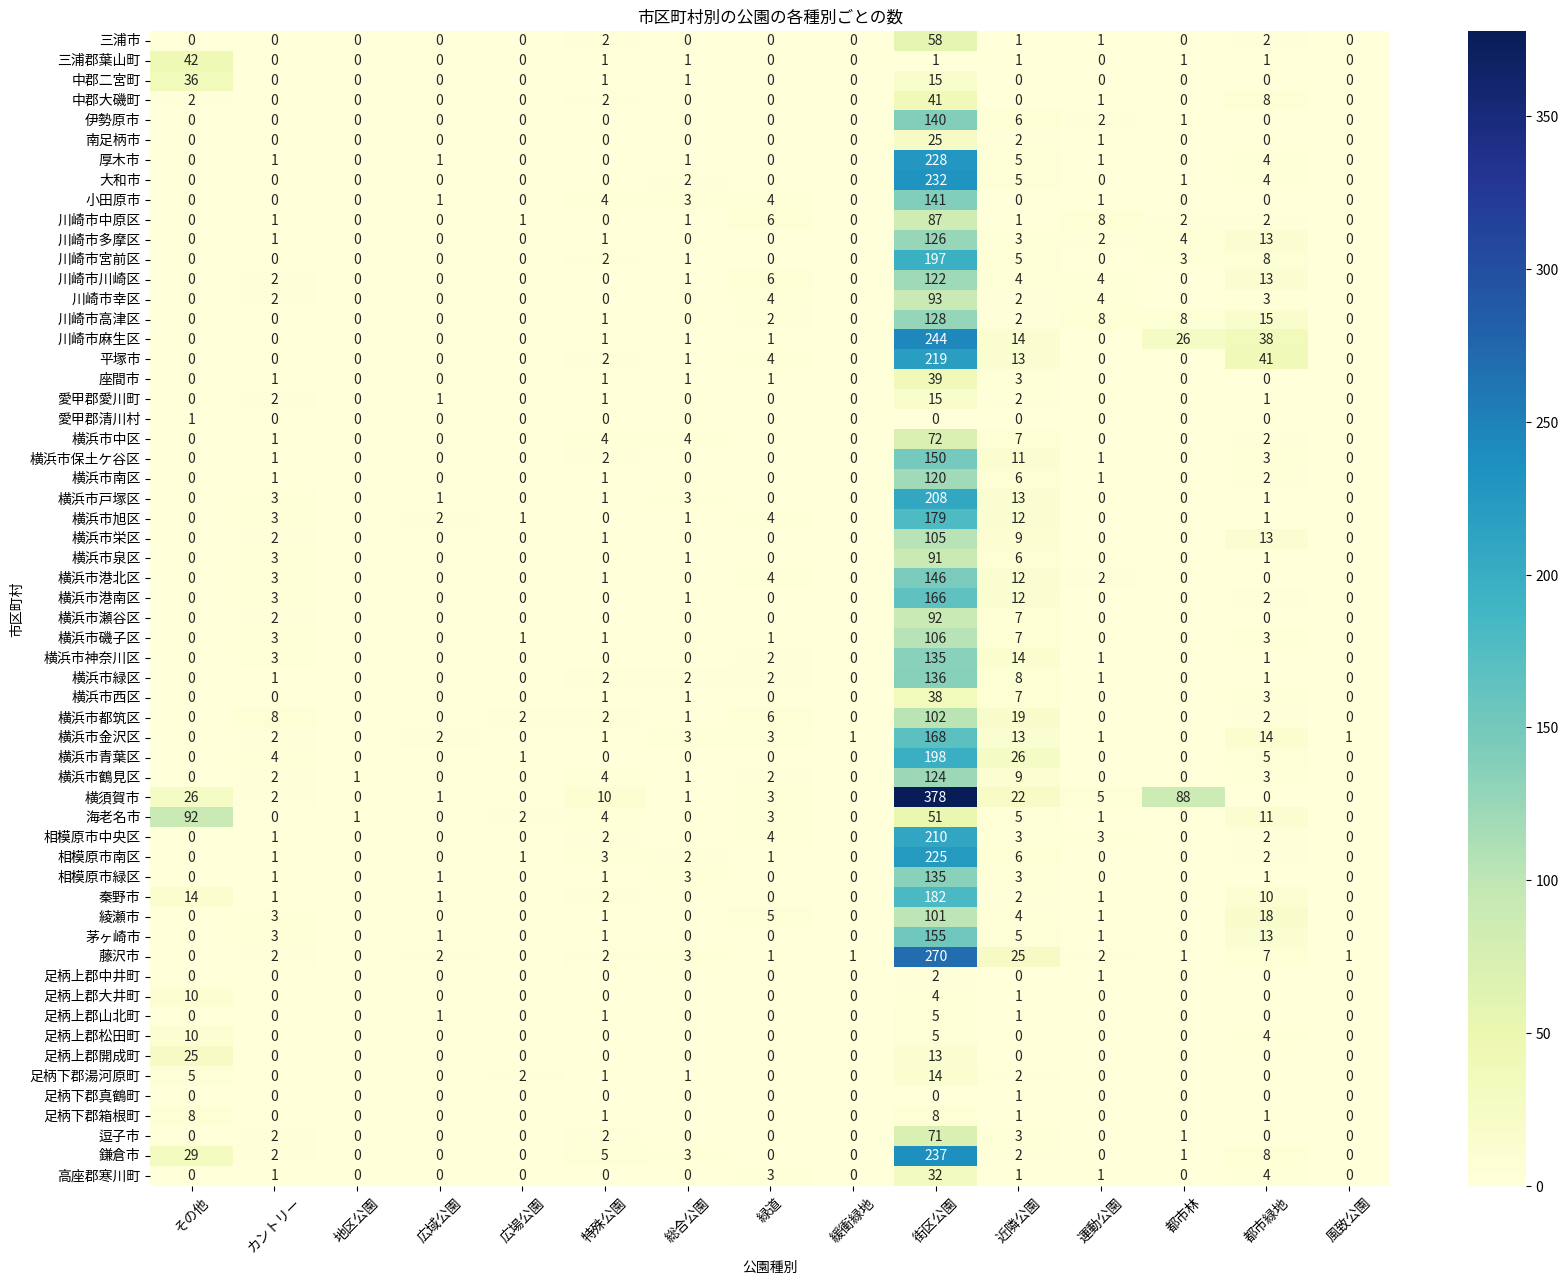

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
# 日本語フォントの指定

import matplotlib as mpl

mpl.rcParams['font.family'] = 'Noto Sans CJK JP' 

file_path_1 = '/home/yasumasa-tezuka/intern_data/140007_park_(神奈川県公園データ)_修正版.xlsx'
# 公園データの読み込み
park_data = pd.read_excel(file_path_1)
#140007_park_(神奈川県公園データ)_修正版.xlsxファイルの「面積」の項目を「公園面積」に変更
park_data['公園種別'] = park_data['公園種別'].replace('特殊公園（風致公園、動植物公園、歴史公園、墓園）', '特殊公園')
park_data['公園種別'] = park_data['公園種別'].replace('地区公園（カントリーパーク）', 'カントリー')

# '面積' と '提供開始年' を数値に変換
park_data['公園面積'] = pd.to_numeric(df['公園面積'], errors='coerce')
park_data['提供開始年'] = pd.to_numeric(df['提供開始年'], errors='coerce')

# 分析 1: 公園種別ごとの公園の数
count_park_type = park_data['公園種別'].value_counts()

# 分析 2: 市区町村別の公園の平均面積
# average_area_by_municipality = park_data.groupby('市区町村')['面積'].mean().sort_values(ascending=False)

# 分析 3: 市区町村別の公園の平均提供開始年
average_year_by_municipality = park_data.groupby('市区町村')['提供開始年'].mean().sort_values(ascending=False)

# 可視化
# plt.figure(figsize=(10, 6))
# count_park_type.plot(kind='bar')
# plt.title('公園種別ごとの公園の数')
# plt.xlabel('公園種別')
# plt.ylabel('数')
# plt.show()
# '面積' 列を数値に変換
park_data['公園面積'] = pd.to_numeric(df['公園面積'], errors='coerce')

# NaN 値を含む行を削除
park_data.dropna(subset=['公園面積'], inplace=True)

# 市区町村別の公園の平均面積を計算
average_area_by_municipality = park_data.groupby('市区町村')['公園面積'].mean().sort_values(ascending=True)

# 上位10個と下位10個を抽出
top_10 = average_area_by_municipality.tail(10)
bottom_10 = average_area_by_municipality.head(10)

# カラーマッピングの作成
colors = ['green' if municipality in top_10.index else 'red' if municipality in bottom_10.index else 'blue' for municipality in average_area_by_municipality.index]

# 可視化
# plt.figure(figsize=(10, 14))
# average_area_by_municipality.plot(kind='barh', color=colors)
# plt.title('市区町村別の公園の平均面積（緑：面積が多いトップ10、赤：面積が少ないボトム10）')
# plt.xlabel('平均面積 (平方メートル)')
# plt.ylabel('市区町村')
# plt.show()

# plt.figure(figsize=(10, 10))
# average_year_by_municipality.plot(kind='barh')  # 横棒グラフに変更
# plt.xticks(rotation=90, fontsize=8)  # X軸のラベルの回転とフォントサイズ調整
# plt.title('市区町村別の公園の平均提供開始年')
# plt.xlabel('平均提供開始年')
# plt.ylabel('市区町村')
# plt.xlim(1960, 2023)  # 横軸の範囲を1900年から2023年に設定
# plt.show()

# ファイルの読み込み

# df_parks = pd.read_excel(file_path)

# 市区町村と公園種別の関係をクロス集計
park_type_municipality = pd.crosstab(park_data['市区町村'], park_data['公園種別'])

# 可視化
plt.figure(figsize=(20, 15))
sns.heatmap(park_type_municipality, annot=True, fmt="d", cmap="YlGnBu")
plt.title('市区町村別の公園の各種別ごとの数')
plt.xlabel('公園種別')
plt.ylabel('市区町村')
plt.xticks(rotation=45)
# plt.yticks(rotation=45)
plt.show()

In [66]:
#公園種別、所在地、面積、設備
file_path_1 = '/home/yasumasa-tezuka/intern_data/140007_park_(神奈川県公園データ)_修正版.xlsx'
# 公園データの読み込み
park_data = pd.read_excel(file_path_1)

# 面積列を数値型に変換し、NaNを削除（あるいは別の値で置き換え）
park_data['公園面積'] = pd.to_numeric(park_data['公園面積'], errors='coerce')
park_data.dropna(subset=['公園面積'], inplace=True)  # NaNを含む行を削除

# 公園のカテゴリを定義（例：小規模＜1000平方メートル、中規模＜10000平方メートル、大規模≥10000平方メートル）
def categorize_park(area):
    if area < 1000:
        return '小規模'
    elif area < 10000:
        return '中規模'
    else:
        return '大規模'
    
# 各公園にカテゴリを割り当てる
park_data['カテゴリ'] = park_data['公園面積'].apply(categorize_park)

# カテゴリ別に公園の数を集計
category_counts = park_data['カテゴリ'].value_counts()

# 結果を表示
print(category_counts)



カテゴリ
小規模    3855
中規模    3465
大規模     703
Name: count, dtype: int64


In [67]:
# データの読み込み
park_data = pd.read_excel(file_path_1)

# 数値に変換する列のリスト
numeric_columns = ['トイレ', '多目的トイレ', '水飲み・手洗い', 'スプリング遊具・スイング遊具', '砂場', '複合遊具', '健康器具', 'ブランコ', 'すべり台', 'ジャングルジム',
                   '鉄棒', 'シーソー', 'ターザンロープ', 'ローラースライダー', 'ふわふわドーム', '芝生広場', '水遊び', 'ランニングコース', 'テニスコート', 'バスケットゴール',
                   '野球場', 'フットサル場', 'サッカー場', 'スケートパーク', 'プール', '体育館', '陸上競技場', 'ウサギ・モルモット', 'ハムスター', 'ひよこ', '馬・ポニー',
                   'カフェ・飲食施設', '売店', '自動販売機', 'バーベキュー場', 'ドッグラン', '喫煙所', 'イベント広場', '避難場所', '無料駐車場', '有料駐車場', '駐輪場']

# 対象の列のみを数値に変換
for column in numeric_columns:
    park_data[column] = pd.to_numeric(park_data[column], errors='coerce')

# 合計の計算（NaN値は無視される）
sums = park_data[numeric_columns].sum()

# 結果の出力
print(sums)


トイレ               1191.0
多目的トイレ             674.0
水飲み・手洗い           5499.0
スプリング遊具・スイング遊具    1120.0
砂場                3362.0
複合遊具              1700.0
健康器具              1002.0
ブランコ              2655.0
すべり台              2768.0
ジャングルジム            395.0
鉄棒                2270.0
シーソー               280.0
ターザンロープ             82.0
ローラースライダー           31.0
ふわふわドーム              9.0
芝生広場               107.0
水遊び                 28.0
ランニングコース            21.0
テニスコート              72.0
バスケットゴール            42.0
野球場                 76.0
フットサル場               4.0
サッカー場               21.0
スケートパーク              6.0
プール                 53.0
体育館                 13.0
陸上競技場               12.0
ウサギ・モルモット            8.0
ハムスター                1.0
ひよこ                  1.0
馬・ポニー                6.0
カフェ・飲食施設            25.0
売店                  32.0
自動販売機              161.0
バーベキュー場             16.0
ドッグラン                8.0
喫煙所                 27.0
イベント広場              31.0
避難場所               341.0
無料駐車場              126.0


公園種別
街区公園                        6589
近隣公園                         354
その他                          300
都市緑地                         291
都市林                          137
特殊公園（風致公園、動植物公園、歴史公園、墓園）      76
地区公園（カントリーパーク）                74
緑道                            74
運動公園                          57
総合公園                          46
広域公園                          15
広場公園                          11
緩衝緑地                           2
地区公園                           2
風致公園                           2
Name: count, dtype: int64
市区町村
横須賀市        536
川崎市麻生区      325
藤沢市         317
鎌倉市         287
平塚市         282
大和市         244
相模原市南区      242
厚木市         241
横浜市青葉区      234
横浜市戸塚区      230
相模原市中央区     225
川崎市宮前区      216
秦野市         213
横浜市金沢区      209
横浜市旭区       203
横浜市港南区      184
茅ヶ崎市        183
海老名市        170
横浜市港北区      168
横浜市保土ケ谷区    168
川崎市高津区      164
横浜市神奈川区     156
小田原市        154
横浜市緑区       153
川崎市川崎区      152
川崎市多摩区      150
伊勢原市        149
横浜市鶴見区      146
相模原市緑区      145
横浜市都筑

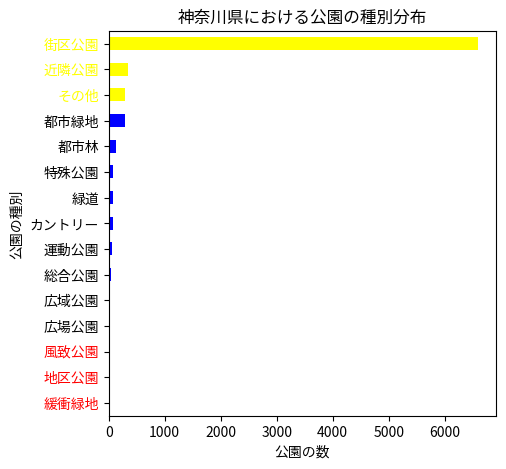

In [101]:
# 公園種別のカウント
park_type_counts = park_data['公園種別'].value_counts()
park_location = park_data['市区町村'].value_counts()
print(park_type_counts)
print(park_location)
# フォントプロパティを設定
font_prop = fm.FontProperties(fname=font_path)
# Matplotlibのデフォルトフォントを更新
plt.rcParams['font.family'] = font_prop.get_name()
#神奈川県における公園の種別分布の可視化
# カテゴリ別に集計
# 公園種別のカウント（降順でソート）

park_data['公園種別'] = park_data['公園種別'].replace('特殊公園（風致公園、動植物公園、歴史公園、墓園）', '特殊公園')
park_data['公園種別'] = park_data['公園種別'].replace('地区公園（カントリーパーク）', 'カントリー')

category_counts = park_data['公園種別'].value_counts(ascending=True)  # 降順でソート

# 上位3つと下位3つの公園種別を識別
top_3_categories = category_counts.head(3).index
bottom_3_categories = category_counts.tail(3).index

# フォントの設定
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

# グラフのサイズを設定
plt.figure(figsize=(5, 5))

# 棒グラフの色を設定
colors = ['red' if category in top_3_categories else 'yellow' if category in bottom_3_categories else 'blue' for category in category_counts.index]

# 棒グラフを描画（数が多いものから順に）
category_counts.plot(kind='barh', color=colors)
plt.title('神奈川県における公園の種別分布')
plt.ylabel('公園の種別')
plt.xlabel('公園の数')

# y軸のラベルに色を設定
for label in plt.gca().get_yticklabels():
    if label.get_text() in top_3_categories:
        label.set_color('red')
    elif label.get_text() in bottom_3_categories:
        label.set_color('yellow')

plt.show()

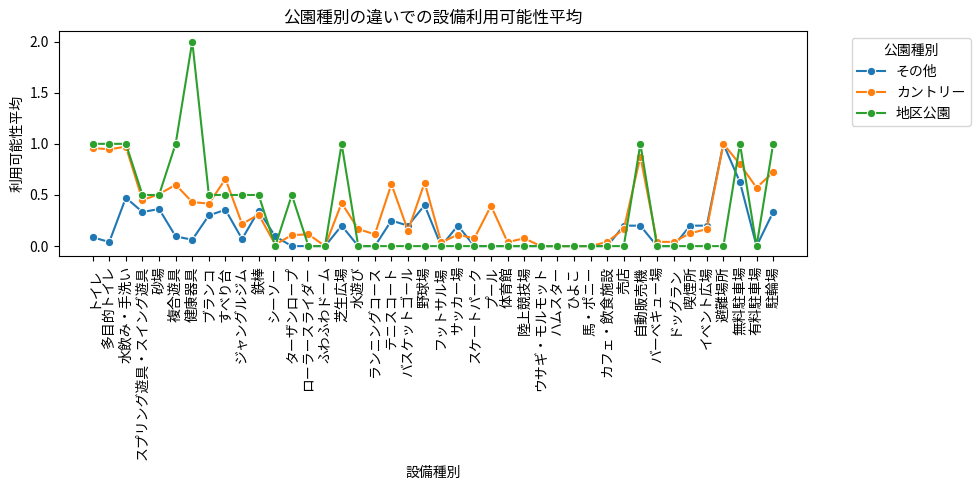

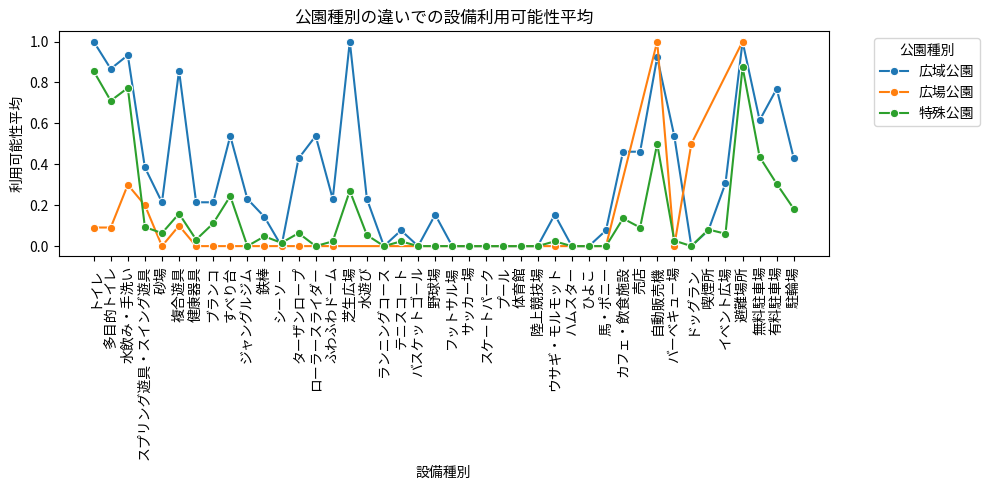

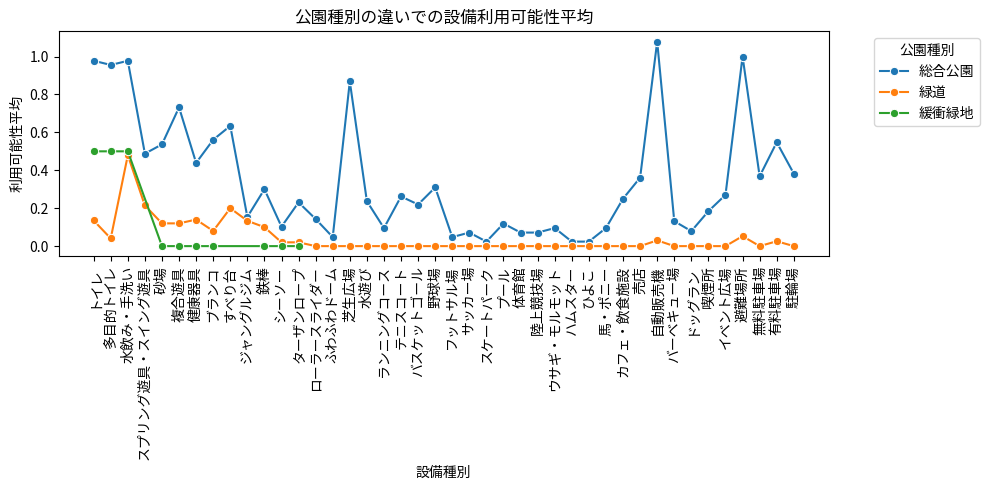

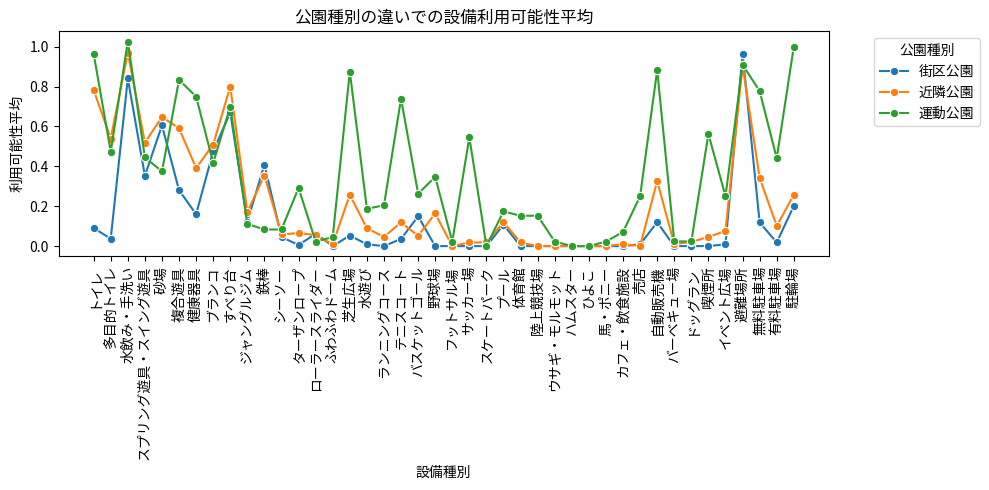

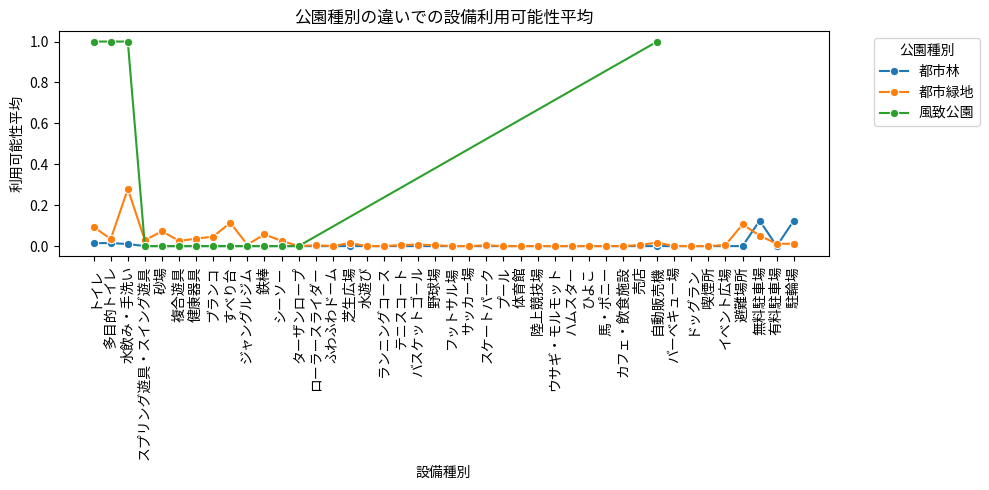

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
from matplotlib import rcParams

# データファイルの読み込み
file_path = '/home/yasumasa-tezuka/intern_data/140007_park_(神奈川県公園データ)_修正版.xlsx'
park_data = pd.read_excel(file_path)

park_data['公園種別'] = park_data['公園種別'].replace('特殊公園（風致公園、動植物公園、歴史公園、墓園）', '特殊公園')
park_data['公園種別'] = park_data['公園種別'].replace('地区公園（カントリーパーク）', 'カントリー')

# 日本語フォントの設定
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'
rcParams['font.family'] = 'Noto Sans CJK JP'
rcParams['font.sans-serif'] = [fm.FontProperties(fname=font_path).get_name()]

# 分析に関連する列の選択
relevant_columns = ['公園種別','トイレ', '多目的トイレ', '水飲み・手洗い', 'スプリング遊具・スイング遊具', '砂場', '複合遊具', '健康器具', 'ブランコ', 'すべり台', 'ジャングルジム',
                   '鉄棒', 'シーソー', 'ターザンロープ', 'ローラースライダー', 'ふわふわドーム', '芝生広場', '水遊び', 'ランニングコース', 'テニスコート', 'バスケットゴール',
                   '野球場', 'フットサル場', 'サッカー場', 'スケートパーク', 'プール', '体育館', '陸上競技場', 'ウサギ・モルモット', 'ハムスター', 'ひよこ', '馬・ポニー',
                   'カフェ・飲食施設', '売店', '自動販売機', 'バーベキュー場', 'ドッグラン', '喫煙所', 'イベント広場', '避難場所', '無料駐車場', '有料駐車場', '駐輪場']

# データフレームのフィルタリング
filtered_data = park_data[relevant_columns]

# 関連する列を数値に変換
for col in relevant_columns[1:]:
    filtered_data.loc[:, col] = pd.to_numeric(filtered_data[col], errors='coerce')

# 公園種別でデータをグループ化し、平均を計算
grouped_data = filtered_data.groupby('公園種別').mean()

# データの転置
transposed_grouped_data = grouped_data.transpose()

# 公園種別のリストを取得
park_types = grouped_data.index.tolist()

# 公園種別を3つずつに分けて、5つのグラフを生成
for i in range(0, len(park_types), 3):
    plt.figure(figsize=(10, 5))
    # 現在のグループの公園種別
    current_park_types = park_types[i:i+3]

    for park_type in current_park_types:
        sns.lineplot(data=transposed_grouped_data[park_type], label=park_type,marker='o')

    # グラフのカスタマイズ
    plt.title('公園種別の違いでの設備利用可能性平均')
    plt.xlabel('設備種別')
    plt.ylabel('利用可能性平均')
    plt.xticks(rotation=90)
    plt.legend(title='公園種別', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


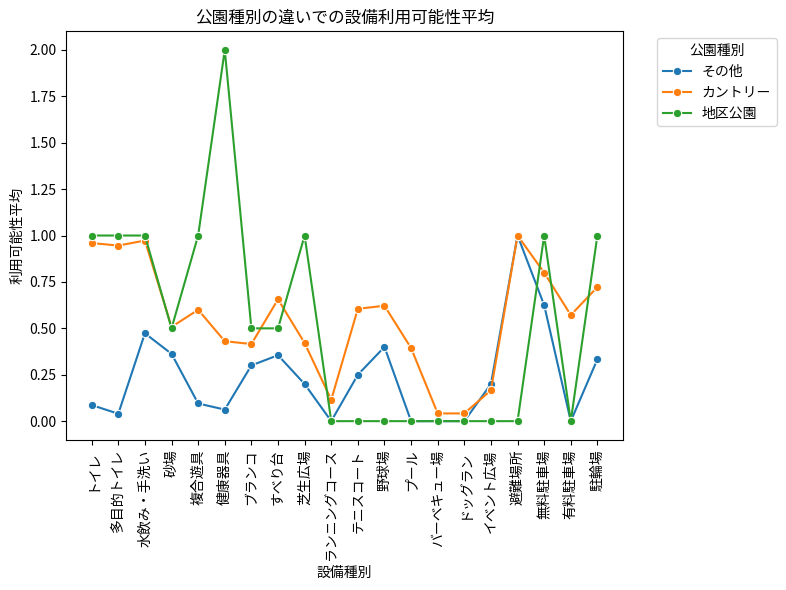

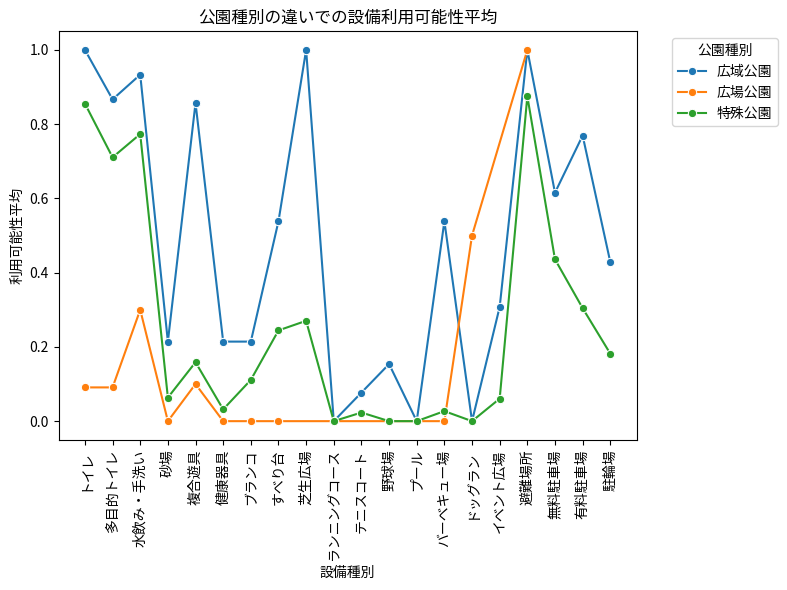

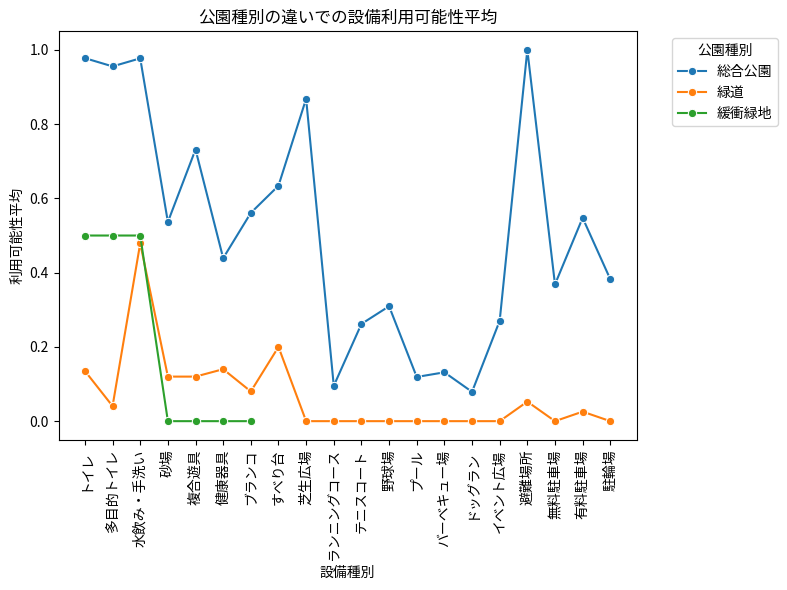

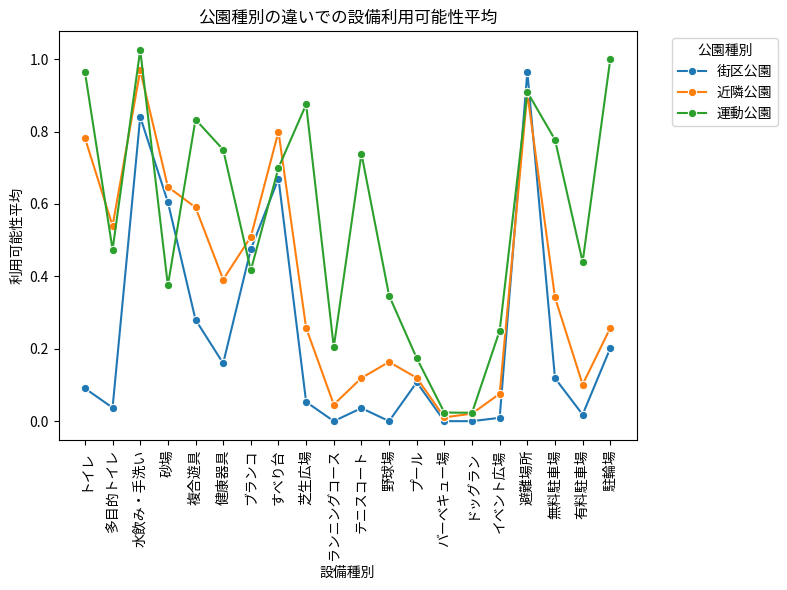

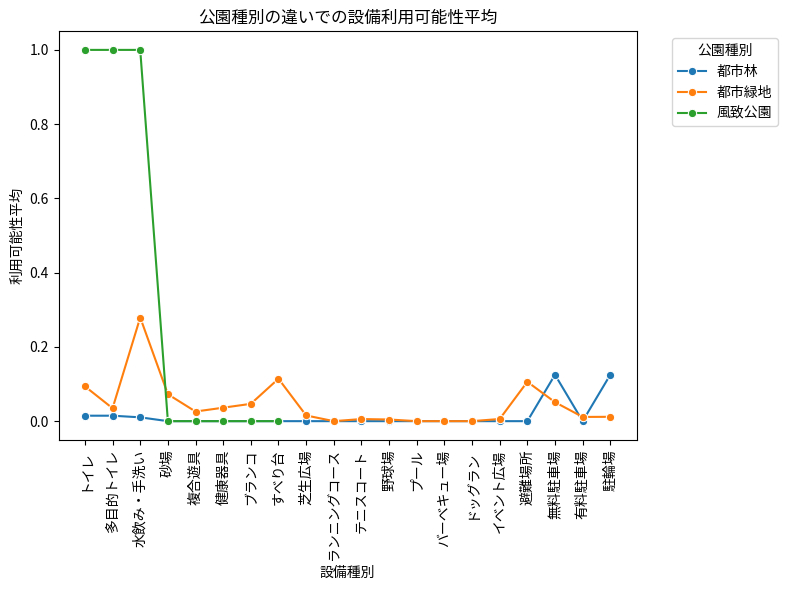

In [105]:
#20の設備に限定
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
from matplotlib import rcParams

# データファイルの読み込み
file_path = '/home/yasumasa-tezuka/intern_data/140007_park_(神奈川県公園データ)_修正版.xlsx'
park_data = pd.read_excel(file_path)

park_data['公園種別'] = park_data['公園種別'].replace('特殊公園（風致公園、動植物公園、歴史公園、墓園）', '特殊公園')
park_data['公園種別'] = park_data['公園種別'].replace('地区公園（カントリーパーク）', 'カントリー')

# 日本語フォントの設定
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'
rcParams['font.family'] = 'Noto Sans CJK JP'
rcParams['font.sans-serif'] = [fm.FontProperties(fname=font_path).get_name()]

# 分析に関連する列の選択
relevant_columns = ['公園種別','トイレ', '多目的トイレ', '水飲み・手洗い','砂場', '複合遊具', '健康器具', 'ブランコ', 'すべり台','芝生広場', 'ランニングコース', 'テニスコート'
                    ,'野球場','プール', 'バーベキュー場', 'ドッグラン', 'イベント広場', '避難場所', '無料駐車場', '有料駐車場', '駐輪場']

# データフレームのフィルタリング
filtered_data = park_data[relevant_columns]

# 関連する列を数値に変換
for col in relevant_columns[1:]:
    filtered_data.loc[:, col] = pd.to_numeric(filtered_data[col], errors='coerce')

# 公園種別でデータをグループ化し、平均を計算
grouped_data = filtered_data.groupby('公園種別').mean()

# データの転置
transposed_grouped_data = grouped_data.transpose()

# 公園種別のリストを取得
park_types = grouped_data.index.tolist()

# 公園種別を3つずつに分けて、5つのグラフを生成
for i in range(0, len(park_types), 3):
    plt.figure(figsize=(8, 6))
    # 現在のグループの公園種別
    current_park_types = park_types[i:i+3]

    for park_type in current_park_types:
        sns.lineplot(data=transposed_grouped_data[park_type], label=park_type,marker='o')

    # グラフのカスタマイズ
    plt.title('公園種別の違いでの設備利用可能性平均')
    plt.xlabel('設備種別')
    plt.ylabel('利用可能性平均')
    plt.xticks(rotation=90)
    plt.legend(title='公園種別', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


<Figure size 1000x1000 with 0 Axes>

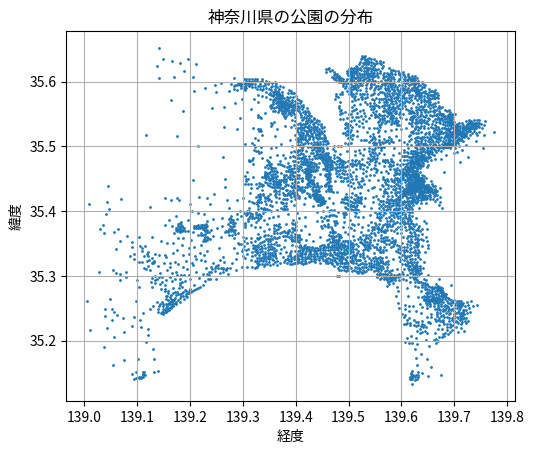

   トイレ 多目的トイレ 無料駐車場 有料駐車場  公園数
0    -      -     -     -   11
1    0      0     -     -  353
2    0      0     0     0  283
3    0      0     0     1    2
4    0      0     1     0    4
5    0      0     1     1    1
6    0      1     0     0    3
7    1      0     -     -  111
8    1      0     -     1    3
9    1      0     0     0   53
10   1      0     0     1    2
11   1      0     1     0   13
12   1      1     -     -  211
13   1      1     -     1   31
14   1      1     0     0   53
15   1      1     0     1   35
16   1      1     1     0   77
17   1      1     1     1   17
18   2      2     1     0    1


In [85]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# CSVファイルのパス
csv = '/home/yasumasa-tezuka/intern_data/公園位置情報.csv'
csv_data = pd.read_csv(csv, encoding='shift_jis')

# CSVデータから緯度と経度の列を使用してGeoDataFrameを作成
gdf = gpd.GeoDataFrame(
    csv_data, 
    geometry=gpd.points_from_xy(csv_data.経度, csv_data.緯度)
)

# CRSを設定（日本の座標系）
gdf.set_crs(epsg=4326, inplace=True)

# 公園の分布を可視化
plt.figure(figsize=(10, 10))
gdf.plot(markersize=1)
plt.title("神奈川県の公園の分布")
plt.xlabel("経度")
plt.ylabel("緯度")
plt.grid(True)
plt.show()

# Excelデータから利便設備に関する列を選択
facilities = park_data[['名称', 'トイレ', '多目的トイレ', '無料駐車場', '有料駐車場']]

# 各設備の有無に基づいてグループ化し、カウント
facility_counts = facilities.groupby(['トイレ', '多目的トイレ', '無料駐車場', '有料駐車場']).size().reset_index(name='公園数')

# 結果の表示
print(facility_counts)

# 利便設備が存在する公園の地理的分布を可視化
# ここでは例としてトイレがある公園をプロット
# toilet_available = csv_data[csv_data.市区町村名.isin(park_data[park_data['トイレ'] == 1]['名称'])]
# gdf_toilet = gpd.GeoDataFrame(
#     toilet_available, 
#     geometry=gpd.points_from_xy(toilet_available.経度, toilet_available.緯度)
# )

# # 可視化
# plt.figure(figsize=(10, 10))
# gdf_toilet.plot(markersize=2)
# plt.title("トイレがある公園の分布")
# plt.xlabel("経度")
# plt.ylabel("緯度")
# plt.grid(True)
# plt.show()


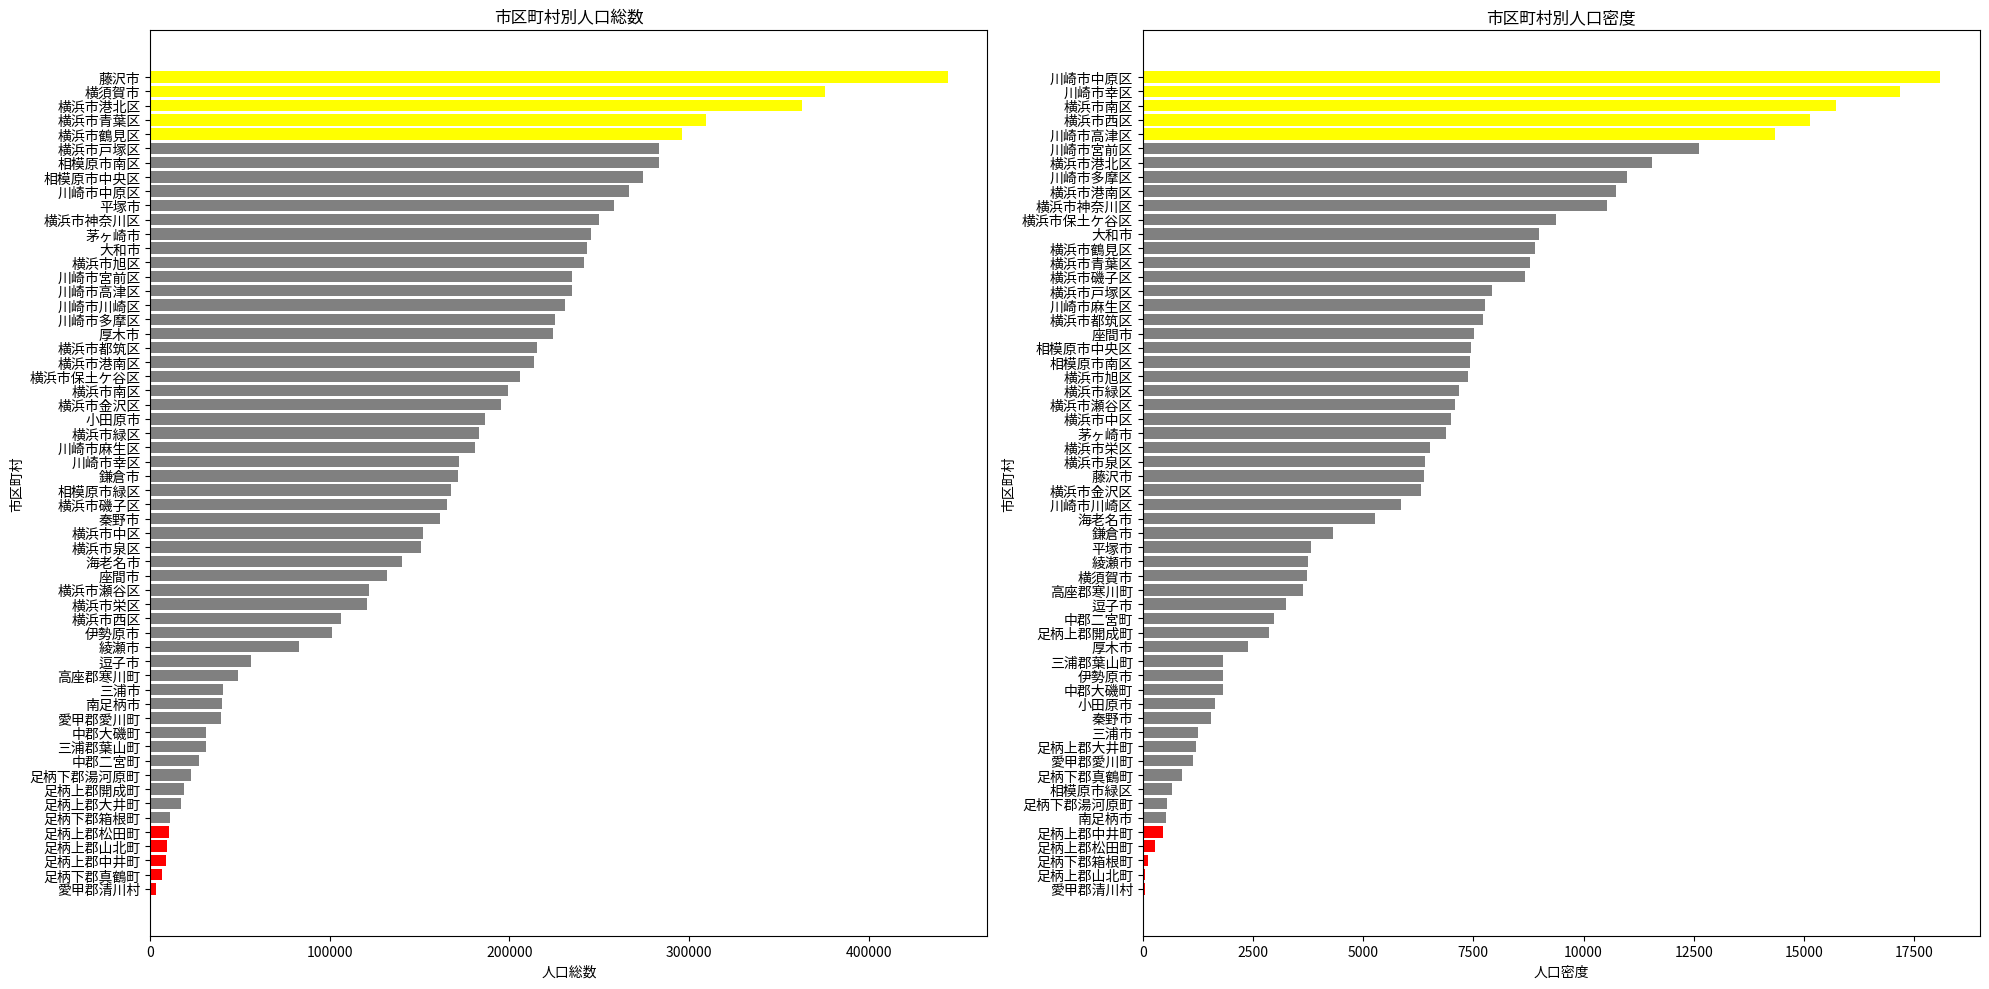

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the uploaded Excel file
file_path_2 = '/home/yasumasa-tezuka/intern_data/jinkotosetai_r5_10.xlsx'
data = pd.read_excel(file_path_2)

# Convert '人口総数' and '人口密度' to numeric values, if not already
data['人口総数'] = pd.to_numeric(data['人口総数'], errors='coerce')
data['人口密度'] = pd.to_numeric(data['人口密度'], errors='coerce')

# Remove rows with NaN values in these columns
data.dropna(subset=['人口総数', '人口密度'], inplace=True)

# Sort data by '人口総数' and '人口密度' in descending order
data_sorted_by_population = data.sort_values(by='人口総数', ascending=False)
data_sorted_by_density = data.sort_values(by='人口密度', ascending=False)

# Identify top 5 and bottom 5 cities/towns for each category
top_5_population = data_sorted_by_population.head(5)['市区町村'].tolist()
bottom_5_population = data_sorted_by_population.tail(5)['市区町村'].tolist()
top_5_density = data_sorted_by_density.head(5)['市区町村'].tolist()
bottom_5_density = data_sorted_by_density.tail(5)['市区町村'].tolist()

# Setting up the plot
plt.figure(figsize=(20, 10))

# Plotting population
plt.subplot(1, 2, 1)
for i, row in data_sorted_by_population[::-1].iterrows():  # 逆順にループ
    color = 'yellow' if row['市区町村'] in top_5_population else 'red' if row['市区町村'] in bottom_5_population else 'grey'
    plt.barh(row['市区町村'], row['人口総数'], color=color)
plt.title('市区町村別人口総数')
plt.xlabel('人口総数')
plt.ylabel('市区町村')

# Plotting population density
plt.subplot(1, 2, 2)
for i, row in data_sorted_by_density[::-1].iterrows():  # 逆順にループ
    color = 'yellow' if row['市区町村'] in top_5_density else 'red' if row['市区町村'] in bottom_5_density else 'grey'
    plt.barh(row['市区町村'], row['人口密度'], color=color)
plt.title('市区町村別人口密度')
plt.xlabel('人口密度')
plt.ylabel('市区町村')

# Show the plot
plt.tight_layout()
plt.show()


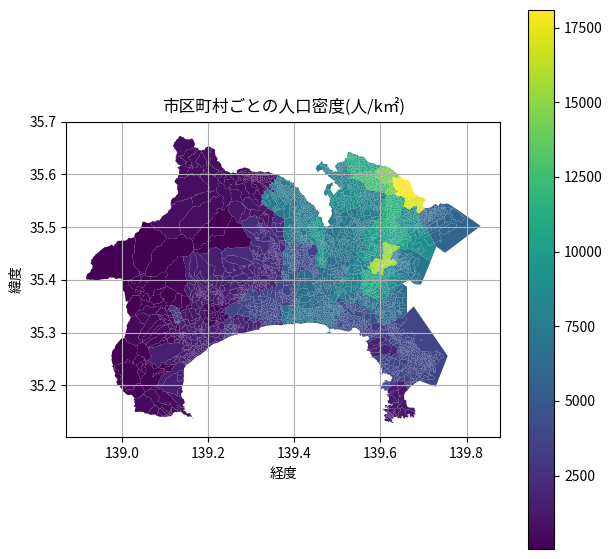

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# 市区町村の境界シェープファイルの読み込み
boundary_file_path = '/home/yasumasa-tezuka/intern_data/境界令和4年/r2ka14.shp'  # 例: 'boundary.shp'
boundary_gdf = gpd.read_file(boundary_file_path)

# # 境界データのプロット
# fig, ax = plt.subplots(figsize=(10, 10))
# boundary_gdf.plot(ax=ax)
# plt.title('市区町村の境界')
# plt.xlabel('経度')
# plt.ylabel('緯度')
# plt.grid(True)
# plt.show()

# #人口密度
file_path_2 = '/home/yasumasa-tezuka/intern_data/jinkotosetai_r5_10_2.xlsx'
population_density = pd.read_excel(file_path_2)

# 'CITY' 列を文字列型に変換
boundary_gdf['CITY'] = boundary_gdf['CITY'].astype(str)
population_density['CITY'] = population_density['CITY'].astype(str)

# 人口密度データを市区町村の境界データと結合
combined_gdf = pd.merge(boundary_gdf, population_density, on='CITY', how='left')

# 人口密度に基づいたマップの作成
fig, ax = plt.subplots(figsize=(7, 7))
combined_gdf.plot(ax=ax, column='人口密度', legend=True, cmap='viridis')

plt.title('市区町村ごとの人口密度(人/k㎡)')
plt.xlabel('経度')
plt.ylabel('緯度')
plt.grid(True)
plt.show()

#人口密度の上に公園の分布→失敗に終わった

In [43]:
#どのようなタイプの公園が多いのか」を調査し（、年齢人口構成との関係から）、望ましいタイプの公園が少ない場合は、どのような施策を行うか
import pandas as pd

# データの読み込み
df_parks = pd.read_excel('/home/yasumasa-tezuka/intern_data/140007_park_(神奈川県公園データ)_修正版.xlsx')
df_population = pd.read_excel('/home/yasumasa-tezuka/intern_data/r5_hyou1-17表11-1.xlsx')

# データの結合
merged_df = pd.merge(df_parks, df_population, on='市区町村')

# 公園種別の集計
park_types_count = df_parks.groupby(['市区町村', '公園種別']).size().unstack().fillna(0)

# 各市区町村ごとの年齢層別人口比率の計算
population_age_group = df_population.groupby('市区町村').sum()
population_age_group['年少人口比率'] = population_age_group['0～14歳'] / population_age_group['総　　数']
population_age_group['生産年齢人口比率'] = population_age_group['15～64歳'] / population_age_group['総　　数']
population_age_group['老年人口比率'] = population_age_group['65歳以上'] / population_age_group['総　　数']

# 公園種別と年齢層別人口比率の相関分析
correlation_1 = park_types_count.corrwith(population_age_group['年少人口比率'])
print(correlation_1)
correlation_2 = park_types_count.corrwith(population_age_group['生産年齢人口比率'])
print(correlation_2)
correlation_3 = park_types_count.corrwith(population_age_group['老年人口比率'])
print(correlation_3)


公園種別
その他                         0.122193
地区公園                        0.161513
地区公園（カントリーパーク）              0.385856
広域公園                        0.020968
広場公園                        0.113870
特殊公園（風致公園、動植物公園、歴史公園、墓園）   -0.000187
総合公園                        0.106846
緑道                          0.347219
緩衝緑地                        0.074747
街区公園                        0.337820
近隣公園                        0.300028
運動公園                        0.169687
都市林                        -0.014554
都市緑地                        0.207502
風致公園                        0.074747
dtype: float64
公園種別
その他                        -0.107700
地区公園                        0.154660
地区公園（カントリーパーク）              0.323033
広域公園                       -0.091846
広場公園                        0.082334
特殊公園（風致公園、動植物公園、歴史公園、墓園）    0.015897
総合公園                        0.152641
緑道                          0.401482
緩衝緑地                        0.009232
街区公園                        0.398813
近隣公園                        0.340836
運動公園         

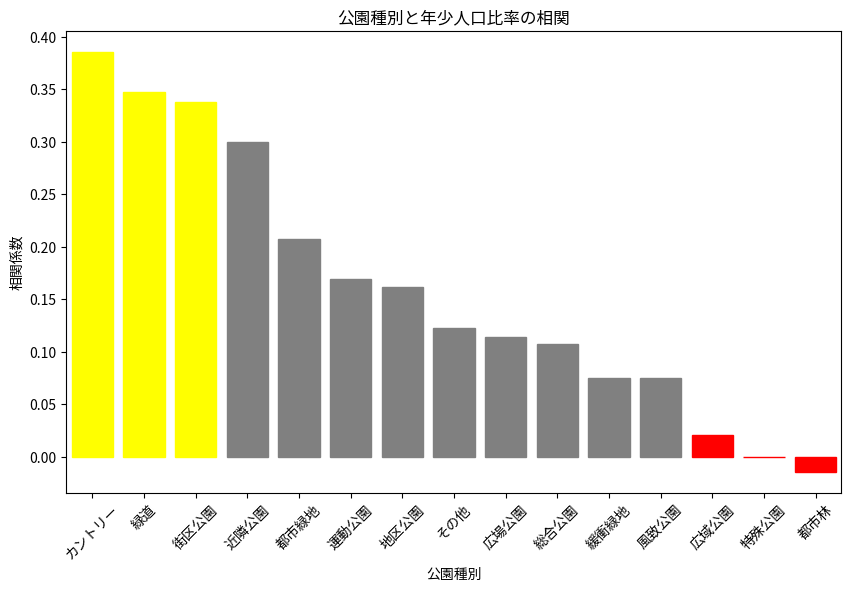

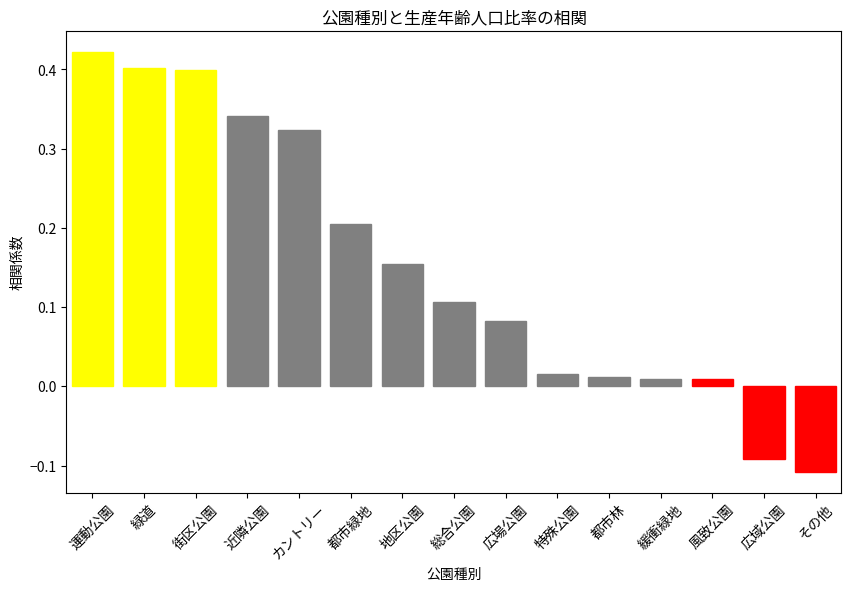

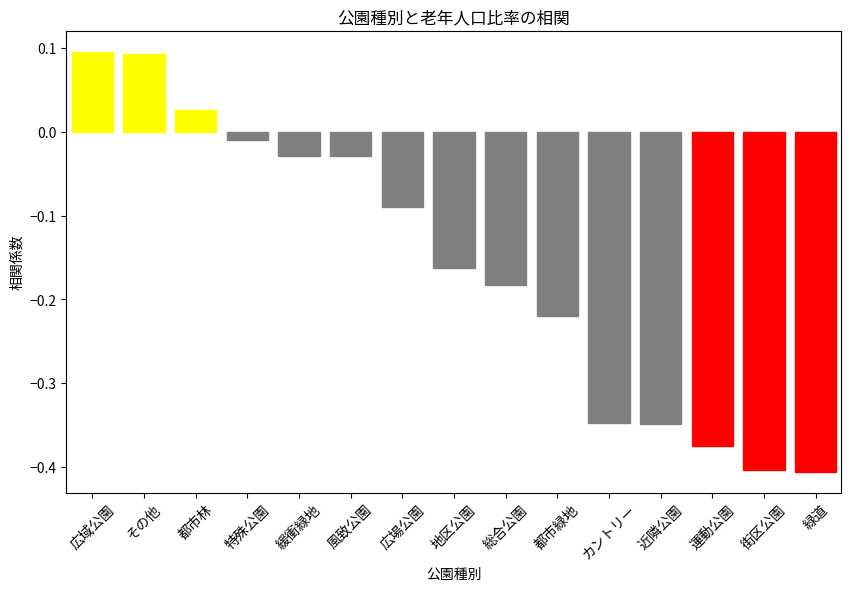

In [44]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# # フォントパス（適切なフォントパスを設定してください）
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc' 

# # フォントプロパティを設定
# font_prop = fm.FontProperties(fname=font_path)
# # Matplotlibのデフォルトフォントを更新
# plt.rcParams['font.family'] = font_prop.get_name()
# 日本語対応フォントパス（例：Noto Sans CJK JP）


# フォントプロパティを設定
font_prop = fm.FontProperties(fname=font_path)
# Matplotlibのデフォルトフォントを更新
plt.rcParams['font.family'] = font_prop.get_name()


# 相関係数のデータを作成
correlation_data = {
    'その他': 0.122193,
    '地区公園': 0.161513,
    'カントリー': 0.385856,
    '広域公園': 0.020968,
    '広場公園': 0.113870,
    '特殊公園': -0.000187,
    '総合公園': 0.106846,
    '緑道': 0.347219,
    '緩衝緑地': 0.074747,
    '街区公園': 0.337820,
    '近隣公園': 0.300028,
    '運動公園': 0.169687,
    '都市林': -0.014554,
    '都市緑地': 0.207502,
    '風致公園': 0.074747
}

# データフレームに変換
correlation_df = pd.DataFrame.from_dict(correlation_data, orient='index', columns=['相関係数'])

# 相関係数を降順にソート
correlation_df_sorted = correlation_df.sort_values(by='相関係数', ascending=False)

# 上位3つと下位3つのカテゴリを特定
top_3_categories = correlation_df_sorted.head(3).index
bottom_3_categories = correlation_df_sorted.tail(3).index

# カテゴリごとの色を設定
colors = correlation_df_sorted.index.map(
    lambda x: 'yellow' if x in top_3_categories else ('red' if x in bottom_3_categories else 'gray')
)

# バーチャートの描画
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=correlation_df_sorted.index, y=correlation_df_sorted['相関係数'])

# 各バーに色を設定
for i, p in enumerate(barplot.patches):
    category = correlation_df_sorted.index[i]
    if category in top_3_categories:
        p.set_color('yellow')
    elif category in bottom_3_categories:
        p.set_color('red')
    else:
        p.set_color('gray')

plt.title("公園種別と年少人口比率の相関")
plt.xlabel("公園種別")
plt.ylabel("相関係数")
plt.xticks(rotation=45)

plt.show()


# 相関係数のデータを作成
correlation_data_1 = {
    'その他': -0.107700,
    '地区公園': 0.154660,
    'カントリー': 0.323033,
    '広域公園': -0.091846,
    '広場公園': 0.082334,
    '特殊公園': 0.015897,
    '総合公園': 0.106846,
    '緑道': 0.401482,
    '緩衝緑地': 0.009232,
    '街区公園': 0.398813,
    '近隣公園': 0.340836,
    '運動公園': 0.422360,
    '都市林': 0.012109,
    '都市緑地': 0.204696,
    '風致公園': 0.009232
}

# データフレームに変換
correlation_df = pd.DataFrame.from_dict(correlation_data_1, orient='index', columns=['相関係数'])

# 相関係数を降順にソート
correlation_df_sorted = correlation_df.sort_values(by='相関係数', ascending=False)

# 上位3つと下位3つのカテゴリを特定
top_3_categories = correlation_df_sorted.head(3).index
bottom_3_categories = correlation_df_sorted.tail(3).index

# カテゴリごとの色を設定
colors = correlation_df_sorted.index.map(
    lambda x: 'yellow' if x in top_3_categories else ('red' if x in bottom_3_categories else 'gray')
)

# バーチャートの描画
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=correlation_df_sorted.index, y=correlation_df_sorted['相関係数'])

# 各バーに色を設定
for i, p in enumerate(barplot.patches):
    category = correlation_df_sorted.index[i]
    if category in top_3_categories:
        p.set_color('yellow')
    elif category in bottom_3_categories:
        p.set_color('red')
    else:
        p.set_color('gray')

plt.title("公園種別と生産年齢人口比率の相関")
plt.xlabel("公園種別")
plt.ylabel("相関係数")
plt.xticks(rotation=45)

plt.show()




# 相関係数のデータを作成
correlation_data_2 = {
    'その他': 0.093231,
    '地区公園': -0.162349,
    'カントリー': -0.347476,
    '広域公園': 0.095408,
    '広場公園':  -0.089507,
    '特殊公園': -0.010295,
    '総合公園': -0.183162,
    '緑道': -0.405428,
    '緩衝緑地': -0.028939,
    '街区公園': -0.403262,
    '近隣公園': -0.348314,
    '運動公園': -0.374247,
    '都市林':  0.026421,
    '都市緑地': -0.219461,
    '風致公園': -0.028939
}
# データフレームに変換
correlation_df = pd.DataFrame.from_dict(correlation_data_2, orient='index', columns=['相関係数'])

# 相関係数を降順にソート
correlation_df_sorted = correlation_df.sort_values(by='相関係数', ascending=False)

# 上位3つと下位3つのカテゴリを特定
top_3_categories = correlation_df_sorted.head(3).index
bottom_3_categories = correlation_df_sorted.tail(3).index

# カテゴリごとの色を設定
colors = correlation_df_sorted.index.map(
    lambda x: 'yellow' if x in top_3_categories else ('red' if x in bottom_3_categories else 'gray')
)

# バーチャートの描画
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=correlation_df_sorted.index, y=correlation_df_sorted['相関係数'])

# 各バーに色を設定
for i, p in enumerate(barplot.patches):
    category = correlation_df_sorted.index[i]
    if category in top_3_categories:
        p.set_color('yellow')
    elif category in bottom_3_categories:
        p.set_color('red')
    else:
        p.set_color('gray')

plt.title("公園種別と老年人口比率の相関")
plt.xlabel("公園種別")
plt.ylabel("相関係数")
plt.xticks(rotation=45)

plt.show()